In [2]:

import sys
import shap 
import time
import pickle
import sklearn 
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from types import SimpleNamespace 




In [13]:


import tensorflow as tf


In [4]:


tfk = tf.keras

tfkl = tf.keras.layers



In [14]:



sys.path.append("../")

from dd_package.data.dyslexia_data import DyslexiaData
from dd_package.data.preprocess import preprocess_data

from dd_package.models.regression_estimators import RegressionEstimators

from dd_package.common.utils import save_a_dict, load_a_dict, print_the_evaluated_results





In [6]:

configs = {
    "models_path": Path("/home/soroosh/Programmes/DD/Models"),
    "results_path": Path("/home/soroosh/Programmes/DD/Results"),
    "figures_path": Path("/home/soroosh/Programmes/DD/Figures"),
    "params_path": Path("/home/soroosh/Programmes/DD/Params"),
    "n_repeats": 10,
    "n_splits": 5,
}

configs = SimpleNamespace(**configs)



In [7]:

data_name="dd_fix_demo"

estimator_name = "mlp-cnn-modified_cls"
to_shuffle = False
to_exclude_at_risk = 0




In [8]:

specifier = data_name + "-" + estimator_name + \
"--shuffled:" + str(to_shuffle) + \
"--exclude at risk:" + str(to_exclude_at_risk)



In [9]:


configs.specifier = specifier
configs.data_name = data_name



In [10]:

configs.specifier



'dd_fix_demo-mlp-cnn-modified_cls--shuffled:False--exclude at risk:0'

# demo_Fix-cls-mm:

- Chosen model: **CNN**



## Load Data

In [10]:

dd = DyslexiaData(path="../../datasets/", n_repeats=5)



In [11]:


if data_name == "dd_demo":
    # dict of dicts, s.t each dict contains pd.df of a class, e.g normal
    _ = dd.get_demo_datasets()  # demos and phonological (which is initially part of demo)
    demo_phono = dd.concat_classes_demo()

    # The optimize way to exclude at-risk class
    if to_exclude_at_risk == 1:
        to_exclude_at_risk = True
        demo_phono = demo_phono.loc[demo_phono.Group != 2]

    df_data_to_use = demo_phono.loc[:, [
                                           'Group', 'SubjectID', 'Sex', 'Grade', 'Age', 'IQ', 'Reading_speed',
                                       ]]
    c_features = ['Sex', 'Grade', ]
    indicators = ['SubjectID', ]
    targets = ["Group", "Reading_speed", ]

elif data_name == "dd_fix_demo":
    # dict of dicts, s.t each dict contains pd.df of a class, e.g normal
    _ = dd.get_demo_datasets()  # demos
    _ = dd.get_fix_datasets()  # fixes

    # concatenate pd.dfs to a pd.df
    fix = dd.concat_classes_fix()
    demo_phono = dd.concat_classes_demo()

    # The optimize way to exclude at-risk class
    if to_exclude_at_risk == 1:
        to_exclude_at_risk = True
        fix = fix.loc[fix.Group != 2]
        demo_phono = demo_phono.loc[demo_phono.Group != 2]

    fix_demo = dd.concat_dfs(
        df1=fix,
        df2=demo_phono,
        features1=fix.columns,
        features2=[
            "Sex", "Grade", "Age", "IQ", "Reading_speed",
        ],
    )

    df_data_to_use = fix_demo
    c_features = ['Sex', 'Grade', ]
    indicators = [
        'SubjectID', 'Sentence_ID', 'Word_Number',
    ]

    targets = ["Group", "Reading_speed", ]
    
elif data_name == "dd_fix":

    # dict of dicts, s.t each dict contains pd.df of a class, e.g normal
    _ = dd.get_fix_datasets()  # fixes
    # concatenate pd.dfs to a pd.df
    fix = dd.concat_classes_fix()

    # The optimize way to exclude at-risk class
    if to_exclude_at_risk == 1:
        to_exclude_at_risk = True
        fix = fix.loc[fix.Group != 2]

    df_data_to_use = fix
    c_features = None
    indicators = [
        'SubjectID', 'Sentence_ID', 'Word_Number',
    ]

    targets = ["Group", ]
    
    

Loading Demo data: 
  dyslexia (72, 9)
  norm (213, 9)
  risk (22, 9)
 
Loading Fixation report data:
  dyslexia (59770, 7)
  norm (139507, 7)
  risk (26073, 7)
 


In [12]:


df_data_to_use



,Group,SubjectID,Sentence_ID,Word_Number,FIX_X,FIX_Y,FIX_DURATION,Sex,Grade,Age,IQ,Reading_speed
0,1,10,4,1,177.3,531.8,219.0,1,4,10,23,102.0
1,1,10,4,2,200.5,545.2,247.0,1,4,10,23,102.0
2,1,10,4,3,282.7,542.4,261.0,1,4,10,23,102.0
3,1,10,4,4,358.1,545.5,268.0,1,4,10,23,102.0
4,1,10,4,4,392.8,536.3,129.0,1,4,10,23,102.0
...,...,...,...,...,...,...,...,...,...,...,...,...
511,3,zrs09,33,5,743.3,562.7,160.0,2,3,10,32,97.0
512,3,zrs09,33,5,772.5,555.8,193.0,2,3,10,32,97.0
513,3,zrs09,33,5,941.7,561.9,219.0,2,3,10,32,97.0
514,3,zrs09,33,5,831.8,548.8,144.0,2,3,10,32,97.0


In [13]:

df_data_to_use.head()



,Group,SubjectID,Sentence_ID,Word_Number,FIX_X,FIX_Y,FIX_DURATION,Sex,Grade,Age,IQ,Reading_speed
0,1,10,4,1,177.3,531.8,219.0,1,4,10,23,102.0
1,1,10,4,2,200.5,545.2,247.0,1,4,10,23,102.0
2,1,10,4,3,282.7,542.4,261.0,1,4,10,23,102.0
3,1,10,4,4,358.1,545.5,268.0,1,4,10,23,102.0
4,1,10,4,4,392.8,536.3,129.0,1,4,10,23,102.0


In [14]:

df_data_to_use.shape




(225350, 12)

In [15]:

df_data_to_use.columns




Index(['Group', 'SubjectID', 'Sentence_ID', 'Word_Number', 'FIX_X', 'FIX_Y',
       'FIX_DURATION', 'Sex', 'Grade', 'Age', 'IQ', 'Reading_speed'],
      dtype='object')

In [16]:


x_org, y_org = dd.get_onehot_features_targets(
    data=df_data_to_use,
    c_features=c_features,
    indicators=indicators,
    targets=targets,
)



In [17]:

x_org.head()



,Grade_2,Sex_2,Grade_4,FIX_DURATION,FIX_X,IQ,Grade_5,Grade_3,FIX_Y,Grade_1,Sex_1,Age,Grade_6
0,0,0,1,219.0,177.3,23,0,0,531.8,0,1,10,0
1,0,0,1,247.0,200.5,23,0,0,545.2,0,1,10,0
2,0,0,1,261.0,282.7,23,0,0,542.4,0,1,10,0
3,0,0,1,268.0,358.1,23,0,0,545.5,0,1,10,0
4,0,0,1,129.0,392.8,23,0,0,536.3,0,1,10,0


In [18]:

features_fixed_order = [
    "FIX_X", "FIX_Y", "FIX_DURATION", "Age", "IQ",
    "Sex_1", "Sex_2", 
    "Grade_1", "Grade_2", "Grade_3", "Grade_4", "Grade_5", "Grade_6"
]


x_org = x_org.loc[:, features_fixed_order]

x_org.head()




,FIX_X,FIX_Y,FIX_DURATION,Age,IQ,Sex_1,Sex_2,Grade_1,Grade_2,Grade_3,Grade_4,Grade_5,Grade_6
0,177.3,531.8,219.0,10,23,1,0,0,0,0,1,0,0
1,200.5,545.2,247.0,10,23,1,0,0,0,0,1,0,0
2,282.7,542.4,261.0,10,23,1,0,0,0,0,1,0,0
3,358.1,545.5,268.0,10,23,1,0,0,0,0,1,0,0
4,392.8,536.3,129.0,10,23,1,0,0,0,0,1,0,0


In [19]:

y_org.head()



,Group,Reading_speed
0,1,102.0
1,1,102.0
2,1,102.0
3,1,102.0
4,1,102.0


In [20]:


estimator_name = "mlp-cnn-modified_cls"

if estimator_name.split("_")[-1] == "reg":
    learning_method = "regression"
    y = y_org.Reading_speed.values

elif estimator_name.split("_")[-1] == "cls":
    learning_method = "classification"
    y = y_org.Group.values

elif estimator_name.split("_")[-1] == "clu":
    from dd_package.models.clustering_estimators import ClusteringEstimators
    y = y_org.Group.values
else:
    assert False, "Undefined algorithm and thus undefined target values"
    
print("learning_method:", learning_method)



learning_method: classification


In [22]:



x = preprocess_data(x=x_org, pp="mm")  # only x is standardized




pre-processing: mm
Preprocessed data shape: (225350, 13)


In [15]:



class_names = ['Norm', 'At-risk', 'Dyslexic'] 


def print_results_per_epochs(results):

    for i in range(1, 11):
        i = str(i)
        y_test_ = results[i]["y_test"]
        y_pred_ = results[i]["y_pred"]
        y_prob_ = results[i]["y_pred_prob"]

        cm = sklearn.metrics.confusion_matrix(
        y_true=y_test_, 
        y_pred=y_pred_
        )

        disp = sklearn.metrics.ConfusionMatrixDisplay(confusion_matrix=cm,
                                  display_labels=class_names
                                 )
        disp.plot()
        plt.show()


        print(
            "Kappa:", sklearn.metrics.cohen_kappa_score(y1=y_test_, y2=y_pred_),

            "AUC ROC:", sklearn.metrics.roc_auc_score(y_test_, y_prob_,
                                                      multi_class="ovr",
                                                      average="weighted")
        )
        
    
    print_the_evaluated_results(results=results, learning_method=learning_method)
        
        
    return None
    
    
    


# Fitting CNN

In [24]:


def split_sequences(features, targets, n_steps):
    
    x, y = list(), list()
    
    for i in range(len(features)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the dataset
        if end_ix > len(features):
            break
        
        # gather input and output parts of the pattern
        seq_x, seq_y = features[i:end_ix, :], targets[i:end_ix]
        x.append(seq_x)
        y.append(seq_y)
        
    return np.array(x, dtype=np.float64), np.array(y)
    
    
    

In [25]:

configs.results_path



PosixPath('/home/soroosh/Programmes/DD/Results')

## Display results

In [26]:


res = load_a_dict(
    name=configs.specifier + "_n_epochs=" + str(10),
    save_path=configs.results_path
        )





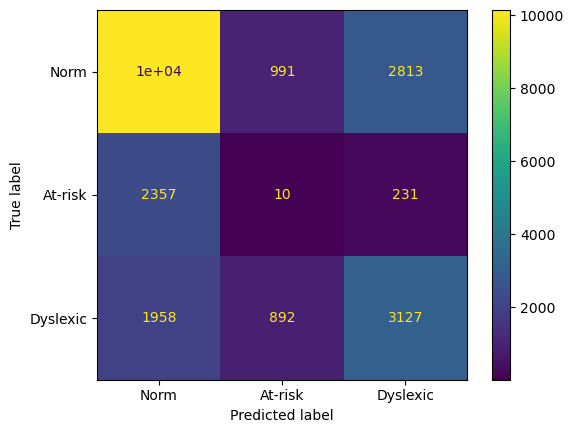

Kappa: 0.2109986463880913 AUC ROC: 0.6411344865657453


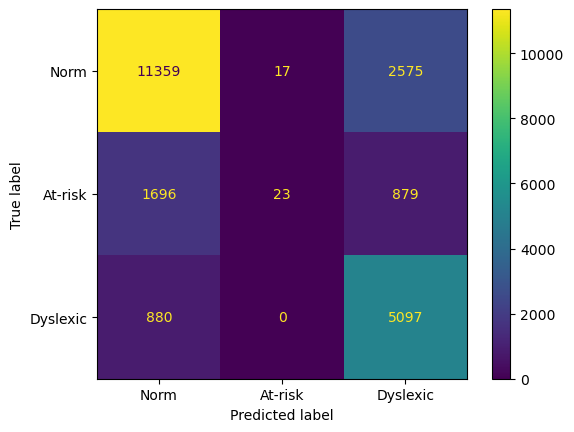

Kappa: 0.4796997897374 AUC ROC: 0.8547125905101157


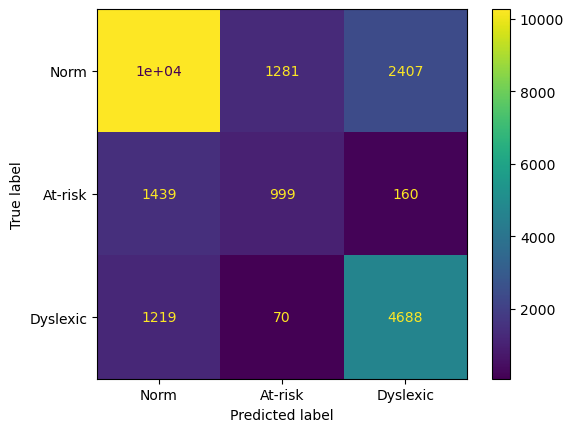

Kappa: 0.4665625510796393 AUC ROC: 0.8095699263366269


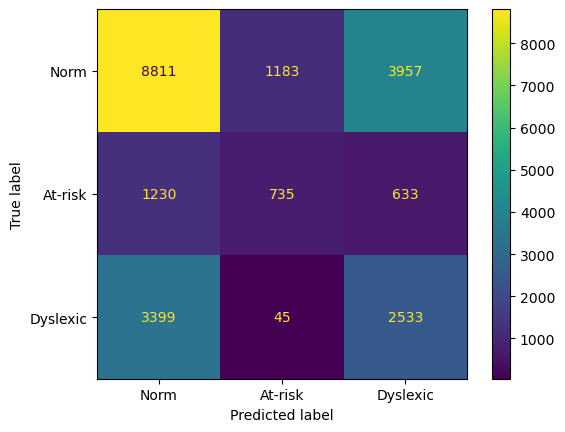

Kappa: 0.13559860824134828 AUC ROC: 0.640379667188248


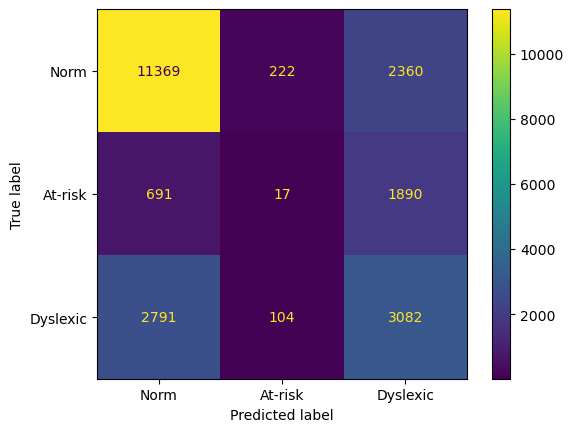

Kappa: 0.2896267174058855 AUC ROC: 0.7041178555154924


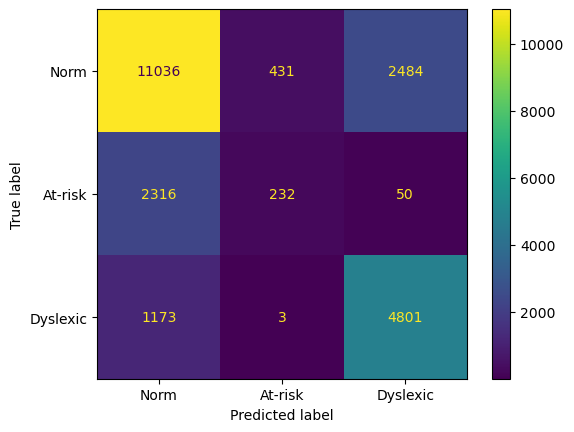

Kappa: 0.4388722974615745 AUC ROC: 0.781592644611965


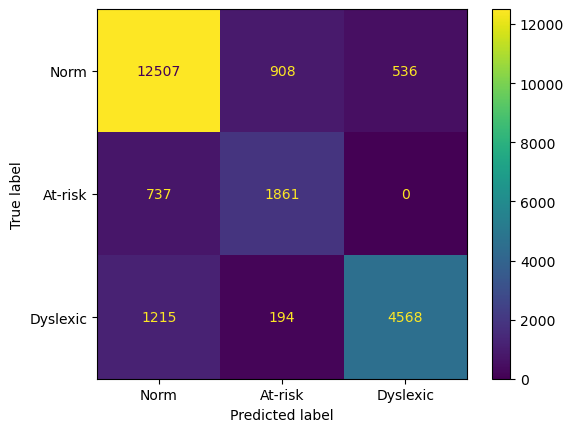

Kappa: 0.6976869624611426 AUC ROC: 0.932592204164547


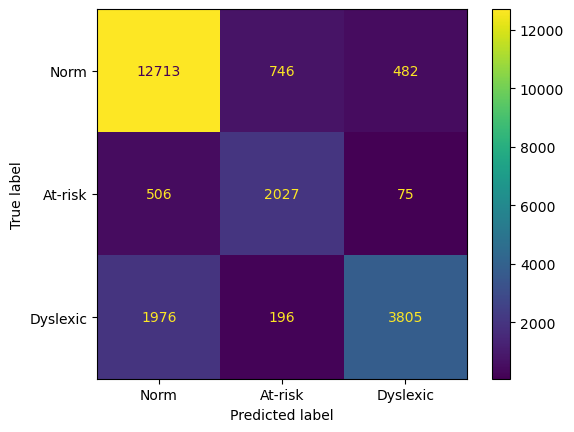

Kappa: 0.657427515598429 AUC ROC: 0.8830565723776106


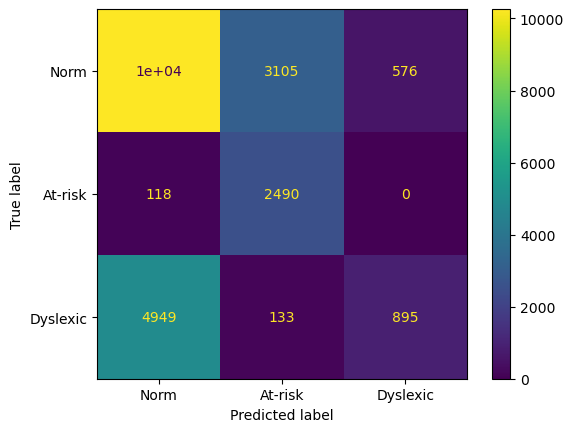

Kappa: 0.25910585253895413 AUC ROC: 0.6730092178510907


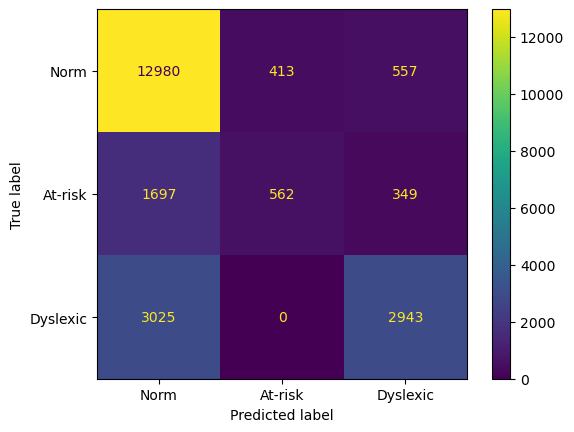

Kappa: 0.4208496510003672 AUC ROC: 0.7480082451846403
  ari    nmi  	 preci 	 recall  	 f1_score  	 roc_auc  	 meape  	 jsd  	 acc 	 tnr
 Ave   std  Ave   std   Ave   std   Ave   std   Ave   std   Ave   std   Ave   std   Ave   std   Ave   std   Ave   std 
0.274 0.151 0.227 0.119 0.685 0.098 0.692 0.094 0.675 0.097 0.767 0.098 16.522 0.229 0.504 0.087 0.692 0.094 0.701 0.084


In [27]:
print_results_per_epochs(res)

In [28]:




data = dd.get_stratified_train_test_splits(
    x=x, y=y,
    labels=y_org.Group.values,
    to_shuffle=False,
    n_splits=10
)



results = {}
n_epochs = 15



for k, v in data.items():
    
    results[k] = {}
    
    # create the models
    n_filters = 32
    kernel_size = 3
    max_pooling_size = 2
    n_outputs = 3
    n_steps = 10

    
    # create the models
    n_filters = 32
    kernel_size = 3
    max_pooling_size = 2
    n_outputs = 3
    n_steps = 10

    

    # define two sets of inputs
    input_demo = tfkl.Input(shape=(10,), name="demographic_input")
    input_fix = tfkl.Input(shape=(n_steps, 3), name="fixation_input")

    # MLP for demographic: the first model operates on the first input:
    a = tfkl.Dense(173, activation="linear", name="demographic_h1")(input_demo)
    a = tfk.Model(inputs=input_demo, outputs=a)


    # CNN for fixation: the second model opreates on the second input
    b = tfkl.Conv1D(filters=n_filters,
               kernel_size=kernel_size,  
               activation="relu",  
               input_shape=(n_steps, 3),  # three fixation features
               name="fixation_conv1")(input_fix)


    b = tfkl.Conv1D(filters=n_filters, 
               kernel_size=kernel_size, 
               activation="relu", 
               name="fixation_conv2",)(b)

    b = tfkl.Dropout(0.1, name="fixation_drop1")(b)
    b = tfkl.MaxPool1D(max_pooling_size, name="fixation_max_pool1")(b)
    b = tfkl.Flatten(name="fixation_flatten1")(b)
    b = tfkl.Dense(units=192, activation='relu', name="fixation_dense1")(b)
    # b = tfkl.Dense(units=n_outputs, activation="softmax", 
    # name="fixation_out")(b)
    b = tfk.Model(inputs=input_fix, outputs=b)


    # combine the output of the two models
    combined = tfkl.concatenate([a.output, b.output], name="concat_demo_fix")

    # apply a FC layer and then a softmax to predict the classes on the combined outputs
    c = tfkl.Dense(100, activation="relu", name="dense_concat1")(combined)
    c = tfkl.Dense(3, activation="softmax", name="class_pred")(c)

    # our model will accept the inputs of the two models and then output a class labels
    mlp_cnn_mdl = tfk.Model(inputs=[a.input, b.input], outputs=c, 
                            name="combined_demo_fix")
    
    

    # prepare data
    xx = np.asarray(v["x_train"]).astype('float32')
    yy = v["y_train"]
    xx_t = np.asarray(v["x_test"]).astype('float32')
    yy_t = v["y_test"]
    
    xx_ , yy_ = split_sequences(xx[:, :3], yy, n_steps=10)
    xx_t_ , yy_t_ = split_sequences(xx_t[:, :3], yy_t, n_steps=10)
    
    _yy = np.subtract(yy, 1, dtype=np.int8)
    _yy_t = np.subtract(yy_t, 1, dtype=np.int8)

    start = time.time()
    
    mlp_cnn_mdl.compile(
            loss="sparse_categorical_crossentropy",
            optimizer=tfk.optimizers.Adam(learning_rate=0.0001), 
            metrics=["accuracy"],
        )
    
    mlp_cnn_mdl.fit(x=[xx[:xx_.shape[0], 3:], xx_,], y=_yy[:xx_.shape[0]],
                   epochs=n_epochs, 
                  )
    
    yy_pred_ = mlp_cnn_mdl.predict([xx_t[:xx_t_.shape[0], 3:], xx_t_,])  # xx_t_
   
    
    end = time.time()
    
    results[k]["x_test"] =xx_t_
    results[k]["y_test"] = _yy_t[:xx_t_.shape[0]]
    results[k]["y_pred"] = yy_pred_.argmax(axis=1)
    results[k]["y_pred_prob"] = yy_pred_
    results[k]["exe_time"] = end - start
    

save_a_dict(
    a_dict=results,
    name=configs.specifier + "_n_epochs=" + str(n_epochs),
    save_path=configs.results_path,
)



2023-07-10 18:20:44.239818: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2023-07-10 18:20:44.239845: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (SorooshShalileh): /proc/driver/nvidia/version does not exist
2023-07-10 18:20:44.240099: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/15
6338/6338 [==============================] - 9s 1ms/step - loss: 0.6228 - accuracy: 0.7300
Epoch 2/15
6338/6338 [==============================] - 14s 2ms/step - loss: 0.5081 - accuracy: 0.7873
Epoch 3/15
6338/6338 [==============================] - 16s 2ms/step - loss: 0.4553 - accuracy: 0.8100
Epoch 4/15
6338/6338 [==============================] - 14s 2ms/step - loss: 0.4187 - accuracy: 0.8250
Epoch 5/15
6338/6338 [==============================] - 9s 1ms/step - loss: 0.3898 - accuracy: 0.8357
Epoch 6/15
6338/6338 [==============================] - 15s 2ms/step - loss: 0.3672 - accuracy: 0.8453
Epoch 7/15
6338/6338 [==============================] - 15s 2ms/step - loss: 0.3471 - accuracy: 0.8537
Epoch 8/15
6338/6338 [==============================] - 8s 1ms/step - loss: 0.3285 - accuracy: 0.8615
Epoch 9/15
6338/6338 [==============================] - 15s 2ms/step - loss: 0.3120 - accuracy: 0.8682
Epoch 10/15
6338/6338 [==============================] - 14s 2ms/step - loss

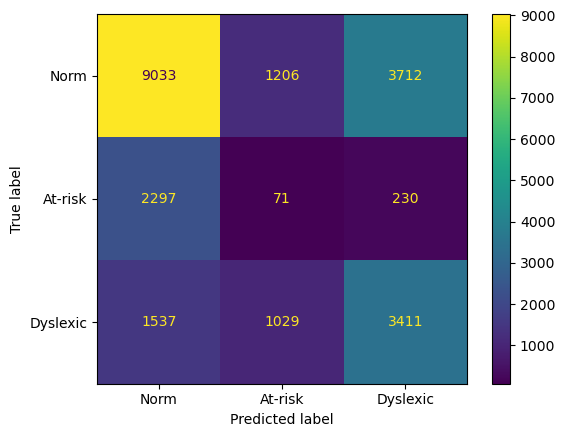

Kappa: 0.1887429687938723 AUC ROC: 0.6164599489447609


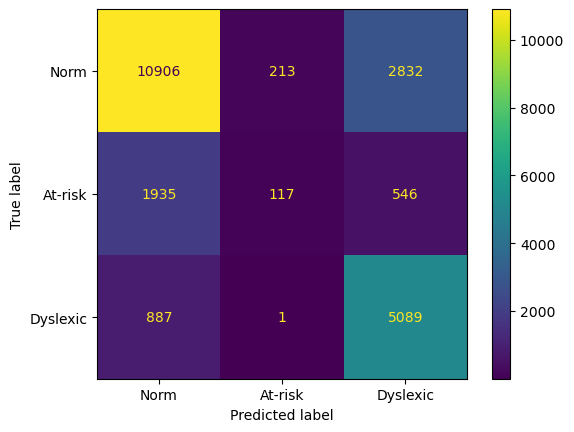

Kappa: 0.4536191204743445 AUC ROC: 0.8127413307948148


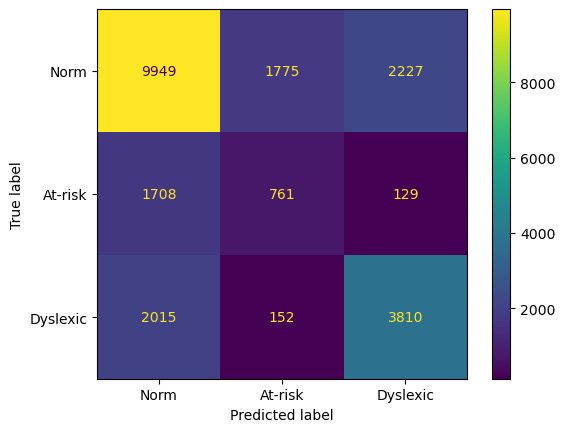

Kappa: 0.33902707646485797 AUC ROC: 0.7601022636866066


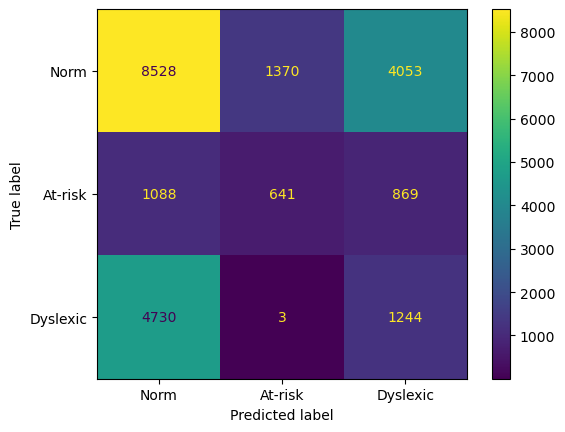

Kappa: -0.02890106376683832 AUC ROC: 0.5007825020876586


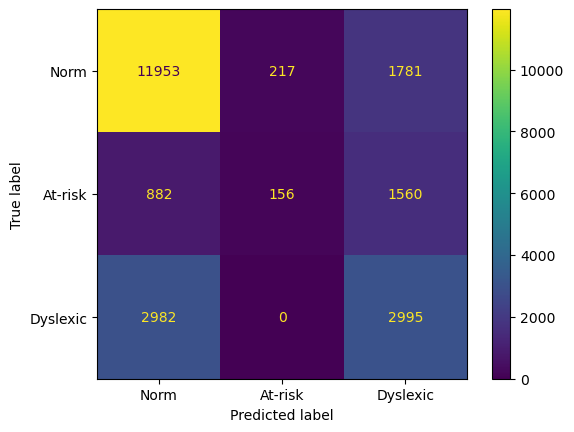

Kappa: 0.32563301689491897 AUC ROC: 0.6795723404642346


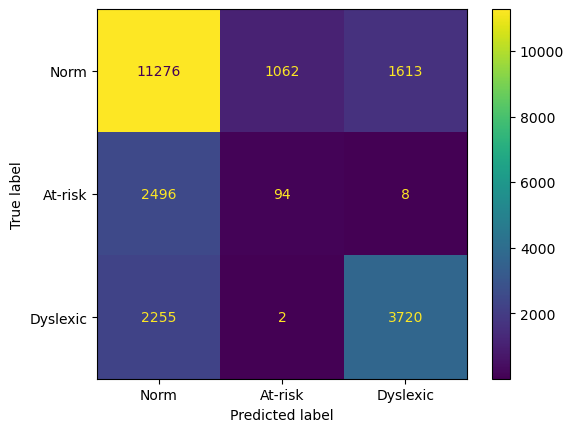

Kappa: 0.3270157211380329 AUC ROC: 0.6714854496865434


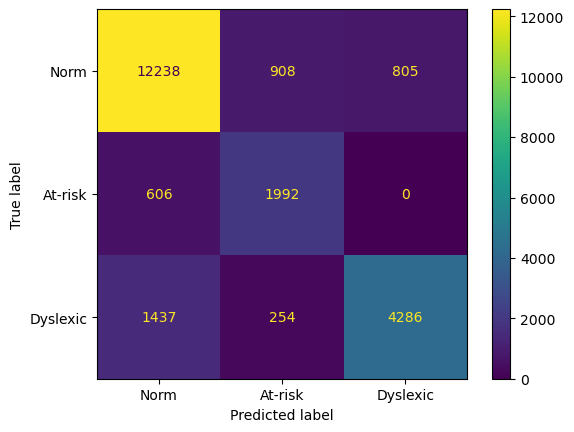

Kappa: 0.6649053818669464 AUC ROC: 0.9210678599654599


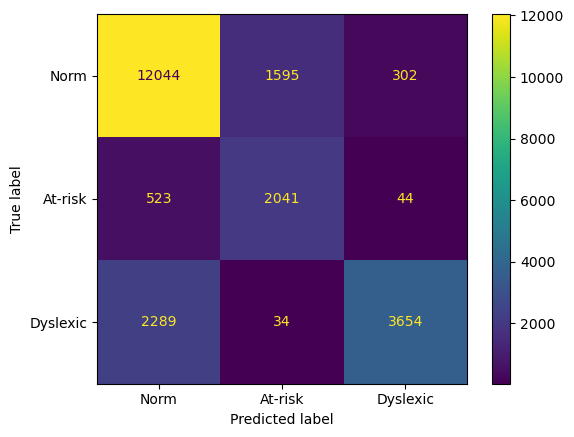

Kappa: 0.5958834528546644 AUC ROC: 0.8990754430555346


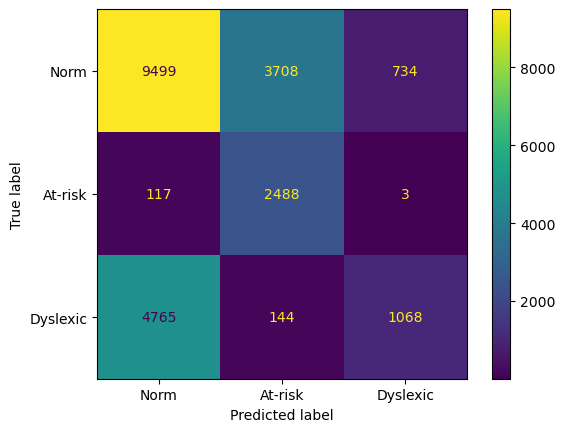

Kappa: 0.23700061460177213 AUC ROC: 0.7015161334811851


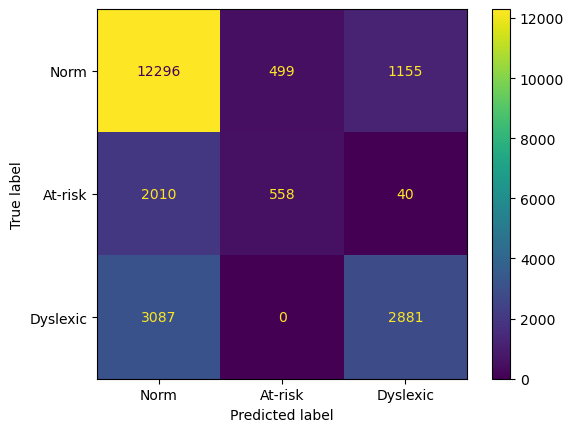

Kappa: 0.3564571346174361 AUC ROC: 0.7278124833191411
  ari    nmi  	 preci 	 recall  	 f1_score  	 roc_auc  	 meape  	 jsd  	 acc 	 tnr
 Ave   std  Ave   std   Ave   std   Ave   std   Ave   std   Ave   std   Ave   std   Ave   std   Ave   std   Ave   std 
0.224 0.141 0.202 0.108 0.656 0.103 0.661 0.102 0.647 0.102 0.729 0.120 16.600 0.168 0.535 0.088 0.661 0.102 0.669 0.092


In [29]:






res = load_a_dict(
    name=configs.specifier + "_n_epochs=" + str(15),
    save_path=configs.results_path
        )

print_results_per_epochs(res)






In [30]:




data = dd.get_stratified_train_test_splits(
    x=x, y=y,
    labels=y_org.Group.values,
    to_shuffle=False,
    n_splits=10
)



results = {}
n_epochs = 20



for k, v in data.items():
    
    results[k] = {}
    
    # create the models
    n_filters = 32
    kernel_size = 3
    max_pooling_size = 2
    n_outputs = 3
    n_steps = 10

    
    # create the models
    n_filters = 32
    kernel_size = 3
    max_pooling_size = 2
    n_outputs = 3
    n_steps = 10

    

    # define two sets of inputs
    input_demo = tfkl.Input(shape=(10,), name="demographic_input")
    input_fix = tfkl.Input(shape=(n_steps, 3), name="fixation_input")

    # MLP for demographic: the first model operates on the first input:
    a = tfkl.Dense(173, activation="linear", name="demographic_h1")(input_demo)
    a = tfk.Model(inputs=input_demo, outputs=a)


    # CNN for fixation: the second model opreates on the second input
    b = tfkl.Conv1D(filters=n_filters,
               kernel_size=kernel_size,  
               activation="relu",  
               input_shape=(n_steps, 3),  # three fixation features
               name="fixation_conv1")(input_fix)


    b = tfkl.Conv1D(filters=n_filters, 
               kernel_size=kernel_size, 
               activation="relu", 
               name="fixation_conv2",)(b)

    b = tfkl.Dropout(0.1, name="fixation_drop1")(b)
    b = tfkl.MaxPool1D(max_pooling_size, name="fixation_max_pool1")(b)
    b = tfkl.Flatten(name="fixation_flatten1")(b)
    b = tfkl.Dense(units=192, activation='relu', name="fixation_dense1")(b)
    # b = tfkl.Dense(units=n_outputs, activation="softmax", 
    # name="fixation_out")(b)
    b = tfk.Model(inputs=input_fix, outputs=b)


    # combine the output of the two models
    combined = tfkl.concatenate([a.output, b.output], name="concat_demo_fix")

    # apply a FC layer and then a softmax to predict the classes on the combined outputs
    c = tfkl.Dense(100, activation="relu", name="dense_concat1")(combined)
    c = tfkl.Dense(3, activation="softmax", name="class_pred")(c)

    # our model will accept the inputs of the two models and then output a class labels
    mlp_cnn_mdl = tfk.Model(inputs=[a.input, b.input], outputs=c, 
                            name="combined_demo_fix")
    
    

    # prepare data
    xx = np.asarray(v["x_train"]).astype('float32')
    yy = v["y_train"]
    xx_t = np.asarray(v["x_test"]).astype('float32')
    yy_t = v["y_test"]
    
    xx_ , yy_ = split_sequences(xx[:, :3], yy, n_steps=10)
    xx_t_ , yy_t_ = split_sequences(xx_t[:, :3], yy_t, n_steps=10)
    
    _yy = np.subtract(yy, 1, dtype=np.int8)
    _yy_t = np.subtract(yy_t, 1, dtype=np.int8)

    start = time.time()
    
    mlp_cnn_mdl.compile(
            loss="sparse_categorical_crossentropy",
            optimizer=tfk.optimizers.Adam(learning_rate=0.0001), 
            metrics=["accuracy"],
        )
    
    mlp_cnn_mdl.fit(x=[xx[:xx_.shape[0], 3:], xx_,], y=_yy[:xx_.shape[0]],
                   epochs=n_epochs, 
                  )
    
    yy_pred_ = mlp_cnn_mdl.predict([xx_t[:xx_t_.shape[0], 3:], xx_t_,])  # xx_t_
   
    
    end = time.time()
    
    results[k]["x_test"] =xx_t_
    results[k]["y_test"] = _yy_t[:xx_t_.shape[0]]
    results[k]["y_pred"] = yy_pred_.argmax(axis=1)
    results[k]["y_pred_prob"] = yy_pred_
    results[k]["exe_time"] = end - start
    

save_a_dict(
    a_dict=results,
    name=configs.specifier + "_n_epochs=" + str(n_epochs),
    save_path=configs.results_path,
)



Epoch 1/20
6338/6338 [==============================] - 12s 2ms/step - loss: 0.6189 - accuracy: 0.7307
Epoch 2/20
6338/6338 [==============================] - 6s 997us/step - loss: 0.5103 - accuracy: 0.7873
Epoch 3/20
6338/6338 [==============================] - 12s 2ms/step - loss: 0.4581 - accuracy: 0.8104
Epoch 4/20
6338/6338 [==============================] - 11s 2ms/step - loss: 0.4193 - accuracy: 0.8261
Epoch 5/20
6338/6338 [==============================] - 8s 1ms/step - loss: 0.3865 - accuracy: 0.8386
Epoch 6/20
6338/6338 [==============================] - 12s 2ms/step - loss: 0.3627 - accuracy: 0.8471
Epoch 7/20
6338/6338 [==============================] - 6s 1ms/step - loss: 0.3420 - accuracy: 0.8555
Epoch 8/20
6338/6338 [==============================] - 12s 2ms/step - loss: 0.3235 - accuracy: 0.8629
Epoch 9/20
6338/6338 [==============================] - 9s 1ms/step - loss: 0.3072 - accuracy: 0.8706
Epoch 10/20
6338/6338 [==============================] - 9s 1ms/step - loss

6338/6338 [==============================] - 12s 2ms/step - loss: 0.2129 - accuracy: 0.9152
Epoch 20/20
6338/6338 [==============================] - 6s 993us/step - loss: 0.2063 - accuracy: 0.9182
Epoch 1/20
6338/6338 [==============================] - 12s 2ms/step - loss: 0.6153 - accuracy: 0.7345
Epoch 2/20
6338/6338 [==============================] - 11s 2ms/step - loss: 0.5170 - accuracy: 0.7847
Epoch 3/20
6338/6338 [==============================] - 7s 1ms/step - loss: 0.4723 - accuracy: 0.8017
Epoch 4/20
6338/6338 [==============================] - 12s 2ms/step - loss: 0.4359 - accuracy: 0.8158
Epoch 5/20
6338/6338 [==============================] - 6s 999us/step - loss: 0.4034 - accuracy: 0.8292
Epoch 6/20
6338/6338 [==============================] - 12s 2ms/step - loss: 0.3739 - accuracy: 0.8419
Epoch 7/20
6338/6338 [==============================] - 12s 2ms/step - loss: 0.3477 - accuracy: 0.8542
Epoch 8/20
6338/6338 [==============================] - 7s 1ms/step - loss: 0.3247

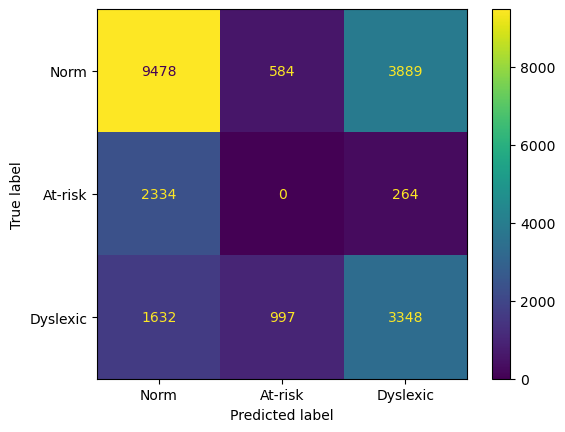

Kappa: 0.19348822526995801 AUC ROC: 0.6309171398597426


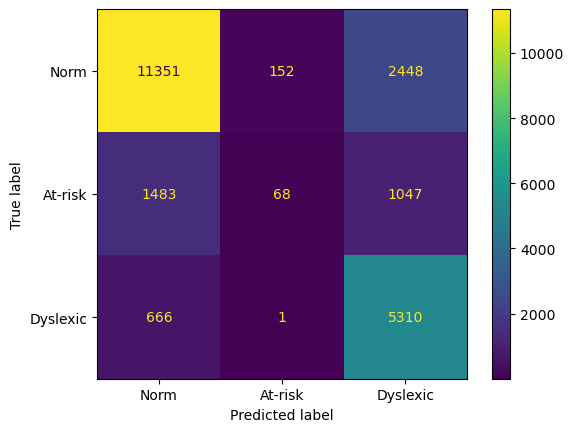

Kappa: 0.5088650510565962 AUC ROC: 0.845790007056481


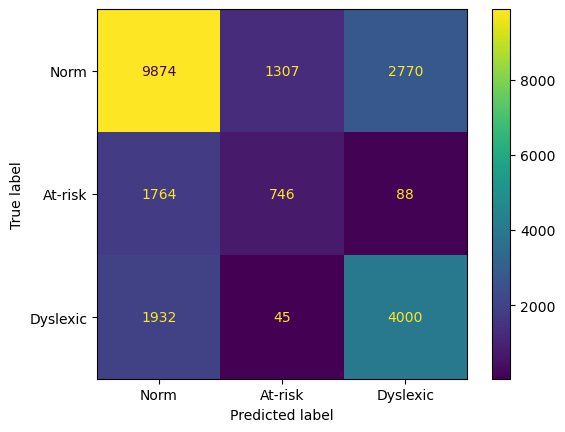

Kappa: 0.34444728225602306 AUC ROC: 0.7517045158383037


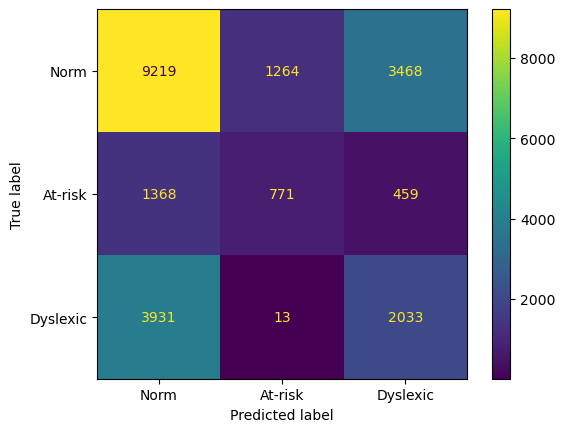

Kappa: 0.10360773458051653 AUC ROC: 0.547822395079718


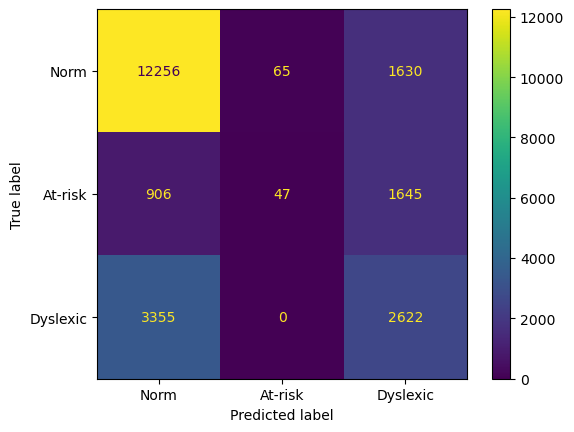

Kappa: 0.2908808504109077 AUC ROC: 0.717760880320611


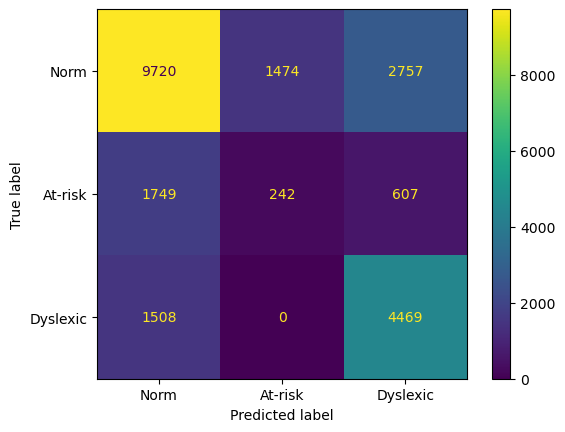

Kappa: 0.33716362633365715 AUC ROC: 0.7425017805246925


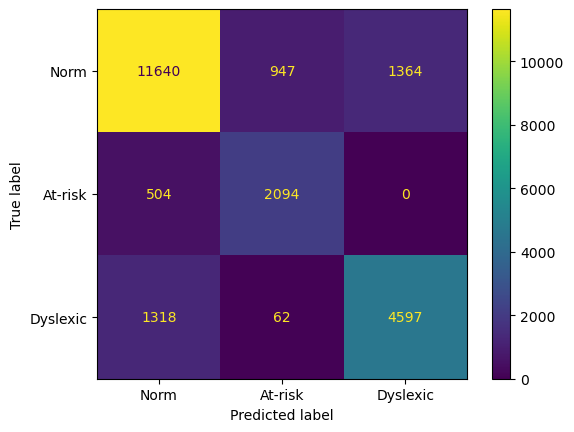

Kappa: 0.6575241168945162 AUC ROC: 0.9157276221976907


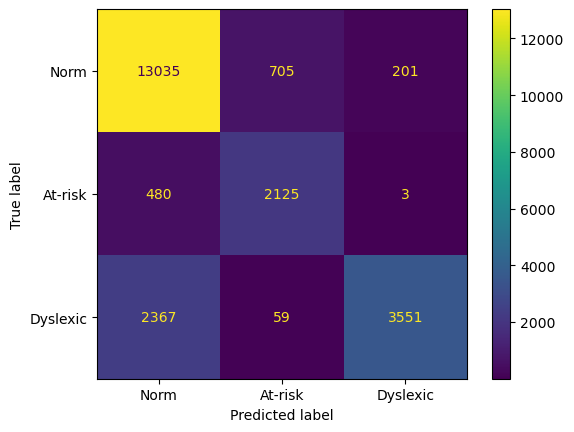

Kappa: 0.6643511930698764 AUC ROC: 0.8920453495359294


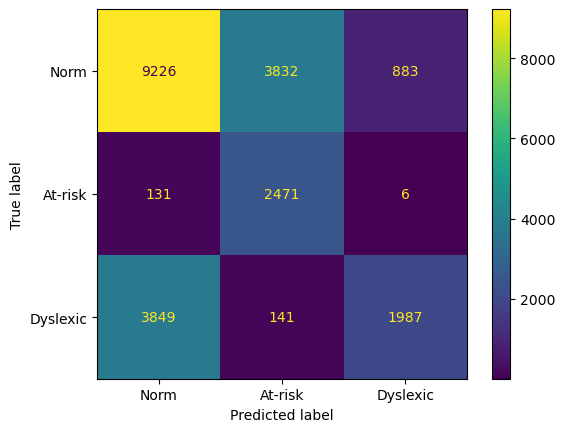

Kappa: 0.3115758533769799 AUC ROC: 0.7334940651747026


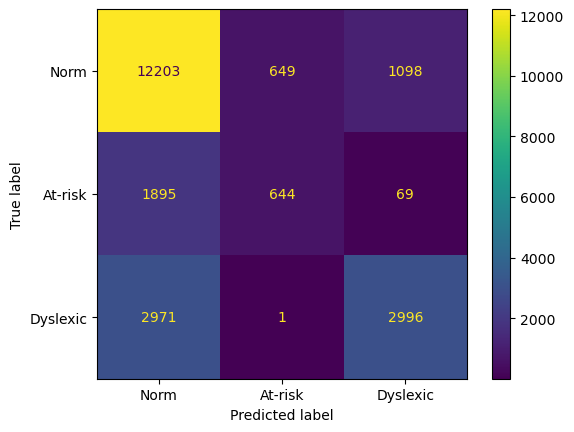

Kappa: 0.3755770109236609 AUC ROC: 0.746113795018376
  ari    nmi  	 preci 	 recall  	 f1_score  	 roc_auc  	 meape  	 jsd  	 acc 	 tnr
 Ave   std  Ave   std   Ave   std   Ave   std   Ave   std   Ave   std   Ave   std   Ave   std   Ave   std   Ave   std 
0.243 0.149 0.214 0.124 0.672 0.096 0.675 0.093 0.662 0.093 0.752 0.106 16.888 0.194 0.517 0.079 0.675 0.093 0.692 0.085


In [31]:




res = load_a_dict(
    name=configs.specifier + "_n_epochs=" + str(20),
    save_path=configs.results_path
        )

print_results_per_epochs(res)



## N_epochs = 50

In [32]:

data = dd.get_stratified_train_test_splits(
    x=x, y=y,
    labels=y_org.Group.values,
    to_shuffle=False,
    n_splits=10
)



results = {}
n_epochs = 50



for k, v in data.items():
    
    results[k] = {}
    
    # create the models
    n_filters = 32
    kernel_size = 3
    max_pooling_size = 2
    n_outputs = 3
    n_steps = 10

    
    # create the models
    n_filters = 32
    kernel_size = 3
    max_pooling_size = 2
    n_outputs = 3
    n_steps = 10

    

    # define two sets of inputs
    input_demo = tfkl.Input(shape=(10,), name="demographic_input")
    input_fix = tfkl.Input(shape=(n_steps, 3), name="fixation_input")

    # MLP for demographic: the first model operates on the first input:
    a = tfkl.Dense(173, activation="linear", name="demographic_h1")(input_demo)
    a = tfk.Model(inputs=input_demo, outputs=a)


    # CNN for fixation: the second model opreates on the second input
    b = tfkl.Conv1D(filters=n_filters,
               kernel_size=kernel_size,  
               activation="relu",  
               input_shape=(n_steps, 3),  # three fixation features
               name="fixation_conv1")(input_fix)


    b = tfkl.Conv1D(filters=n_filters, 
               kernel_size=kernel_size, 
               activation="relu", 
               name="fixation_conv2",)(b)

    b = tfkl.Dropout(0.1, name="fixation_drop1")(b)
    b = tfkl.MaxPool1D(max_pooling_size, name="fixation_max_pool1")(b)
    b = tfkl.Flatten(name="fixation_flatten1")(b)
    b = tfkl.Dense(units=192, activation='relu', name="fixation_dense1")(b)
    # b = tfkl.Dense(units=n_outputs, activation="softmax", 
    # name="fixation_out")(b)
    b = tfk.Model(inputs=input_fix, outputs=b)


    # combine the output of the two models
    combined = tfkl.concatenate([a.output, b.output], name="concat_demo_fix")

    # apply a FC layer and then a softmax to predict the classes on the combined outputs
    c = tfkl.Dense(100, activation="relu", name="dense_concat1")(combined)
    c = tfkl.Dense(3, activation="softmax", name="class_pred")(c)

    # our model will accept the inputs of the two models and then output a class labels
    mlp_cnn_mdl = tfk.Model(inputs=[a.input, b.input], outputs=c, 
                            name="combined_demo_fix")
    
    

    # prepare data
    xx = np.asarray(v["x_train"]).astype('float32')
    yy = v["y_train"]
    xx_t = np.asarray(v["x_test"]).astype('float32')
    yy_t = v["y_test"]
    
    xx_ , yy_ = split_sequences(xx[:, :3], yy, n_steps=10)
    xx_t_ , yy_t_ = split_sequences(xx_t[:, :3], yy_t, n_steps=10)
    
    _yy = np.subtract(yy, 1, dtype=np.int8)
    _yy_t = np.subtract(yy_t, 1, dtype=np.int8)

    start = time.time()
    
    mlp_cnn_mdl.compile(
            loss="sparse_categorical_crossentropy",
            optimizer=tfk.optimizers.Adam(learning_rate=0.0001), 
            metrics=["accuracy"],
        )
    
    mlp_cnn_mdl.fit(x=[xx[:xx_.shape[0], 3:], xx_,], y=_yy[:xx_.shape[0]],
                   epochs=n_epochs, 
                  )
    
    yy_pred_ = mlp_cnn_mdl.predict([xx_t[:xx_t_.shape[0], 3:], xx_t_,])  # xx_t_
   
    
    end = time.time()
    
    results[k]["x_test"] =xx_t_
    results[k]["y_test"] = _yy_t[:xx_t_.shape[0]]
    results[k]["y_pred"] = yy_pred_.argmax(axis=1)
    results[k]["y_pred_prob"] = yy_pred_
    results[k]["exe_time"] = end - start
    

save_a_dict(
    a_dict=results,
    name=configs.specifier + "_n_epochs=" + str(n_epochs),
    save_path=configs.results_path,
)


Epoch 1/50
6338/6338 [==============================] - 12s 2ms/step - loss: 0.6131 - accuracy: 0.7359
Epoch 2/50
6338/6338 [==============================] - 12s 2ms/step - loss: 0.5109 - accuracy: 0.7842
Epoch 3/50
6338/6338 [==============================] - 6s 1ms/step - loss: 0.4598 - accuracy: 0.8069
Epoch 4/50
6338/6338 [==============================] - 12s 2ms/step - loss: 0.4220 - accuracy: 0.8227
Epoch 5/50
6338/6338 [==============================] - 6s 1ms/step - loss: 0.3901 - accuracy: 0.8366
Epoch 6/50
6338/6338 [==============================] - 12s 2ms/step - loss: 0.3620 - accuracy: 0.8474
Epoch 7/50
6338/6338 [==============================] - 11s 2ms/step - loss: 0.3379 - accuracy: 0.8575
Epoch 8/50
6338/6338 [==============================] - 7s 1ms/step - loss: 0.3156 - accuracy: 0.8679
Epoch 9/50
6338/6338 [==============================] - 12s 2ms/step - loss: 0.2958 - accuracy: 0.8769
Epoch 10/50
6338/6338 [==============================] - 6s 1ms/step - loss:

6338/6338 [==============================] - 7s 1ms/step - loss: 0.3029 - accuracy: 0.8745
Epoch 10/50
6338/6338 [==============================] - 12s 2ms/step - loss: 0.2889 - accuracy: 0.8806
Epoch 11/50
6338/6338 [==============================] - 6s 1ms/step - loss: 0.2754 - accuracy: 0.8861
Epoch 12/50
6338/6338 [==============================] - 12s 2ms/step - loss: 0.2626 - accuracy: 0.8918
Epoch 13/50
6338/6338 [==============================] - 11s 2ms/step - loss: 0.2512 - accuracy: 0.8966
Epoch 14/50
6338/6338 [==============================] - 7s 1ms/step - loss: 0.2416 - accuracy: 0.9009
Epoch 15/50
6338/6338 [==============================] - 12s 2ms/step - loss: 0.2322 - accuracy: 0.9045
Epoch 16/50
6338/6338 [==============================] - 6s 1000us/step - loss: 0.2237 - accuracy: 0.9074
Epoch 17/50
6338/6338 [==============================] - 12s 2ms/step - loss: 0.2157 - accuracy: 0.9109
Epoch 18/50
6338/6338 [==============================] - 6s 1ms/step - loss: 

6338/6338 [==============================] - 6s 1ms/step - loss: 0.2247 - accuracy: 0.9103
Epoch 18/50
6338/6338 [==============================] - 12s 2ms/step - loss: 0.2170 - accuracy: 0.9140
Epoch 19/50
6338/6338 [==============================] - 6s 1ms/step - loss: 0.2099 - accuracy: 0.9173
Epoch 20/50
6338/6338 [==============================] - 12s 2ms/step - loss: 0.2028 - accuracy: 0.9198
Epoch 21/50
6338/6338 [==============================] - 11s 2ms/step - loss: 0.1969 - accuracy: 0.9227
Epoch 22/50
6338/6338 [==============================] - 8s 1ms/step - loss: 0.1910 - accuracy: 0.9254
Epoch 23/50
6338/6338 [==============================] - 12s 2ms/step - loss: 0.1861 - accuracy: 0.9272
Epoch 24/50
6338/6338 [==============================] - 6s 1ms/step - loss: 0.1815 - accuracy: 0.9292
Epoch 25/50
6338/6338 [==============================] - 12s 2ms/step - loss: 0.1757 - accuracy: 0.9319
Epoch 26/50
6338/6338 [==============================] - 11s 2ms/step - loss: 0.

6338/6338 [==============================] - 12s 2ms/step - loss: 0.1626 - accuracy: 0.9376
Epoch 26/50
6338/6338 [==============================] - 6s 1ms/step - loss: 0.1589 - accuracy: 0.9393
Epoch 27/50
6338/6338 [==============================] - 12s 2ms/step - loss: 0.1552 - accuracy: 0.9407
Epoch 28/50
6338/6338 [==============================] - 6s 1ms/step - loss: 0.1512 - accuracy: 0.9420
Epoch 29/50
6338/6338 [==============================] - 12s 2ms/step - loss: 0.1475 - accuracy: 0.9434
Epoch 30/50
6338/6338 [==============================] - 11s 2ms/step - loss: 0.1446 - accuracy: 0.9450
Epoch 31/50
6338/6338 [==============================] - 7s 1ms/step - loss: 0.1410 - accuracy: 0.9461
Epoch 32/50
6338/6338 [==============================] - 12s 2ms/step - loss: 0.1382 - accuracy: 0.9471
Epoch 33/50
6338/6338 [==============================] - 6s 1ms/step - loss: 0.1350 - accuracy: 0.9479
Epoch 34/50
6338/6338 [==============================] - 12s 2ms/step - loss: 0.

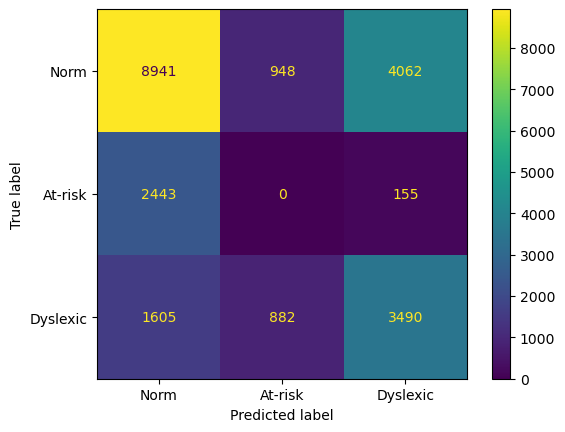

Kappa: 0.17426823543328174 AUC ROC: 0.6261620151273466


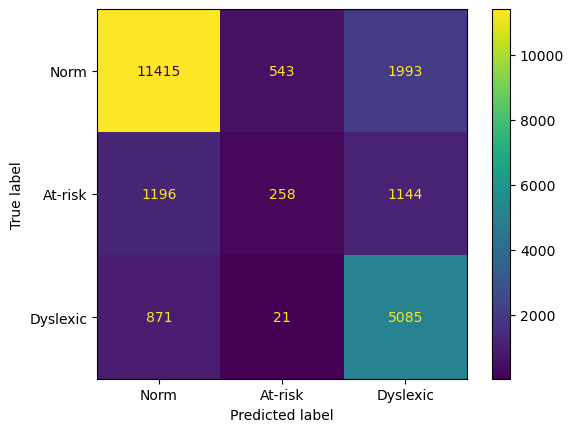

Kappa: 0.5152858793329622 AUC ROC: 0.8379106093524005


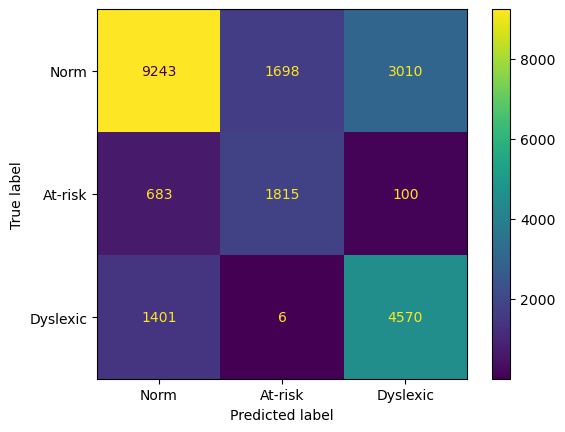

Kappa: 0.47211379524724584 AUC ROC: 0.7889072276121378


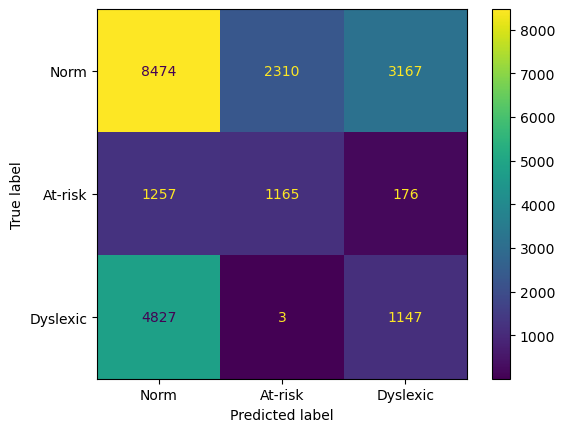

Kappa: 0.014878794086829905 AUC ROC: 0.4783890310702311


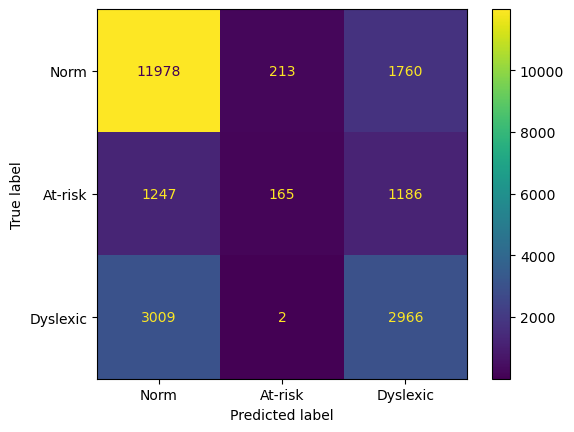

Kappa: 0.3169917653842348 AUC ROC: 0.6926883185471675


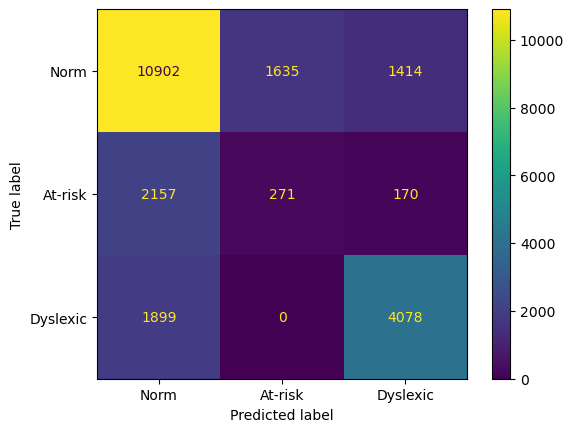

Kappa: 0.3695792439394122 AUC ROC: 0.7387593059267937


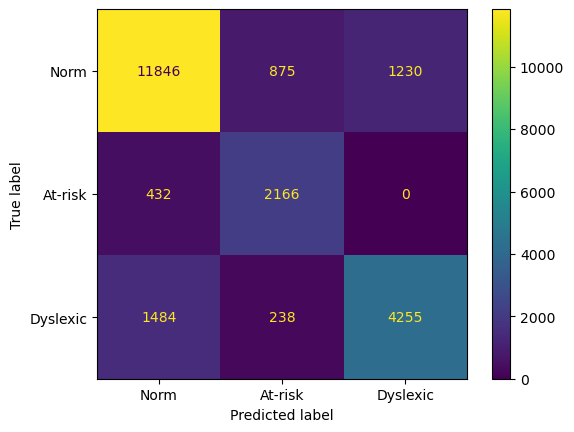

Kappa: 0.6500192629747887 AUC ROC: 0.9030878893674109


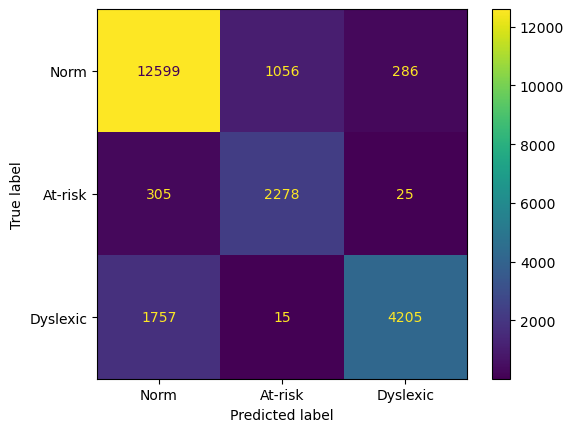

Kappa: 0.7097718257050529 AUC ROC: 0.9097147062056726


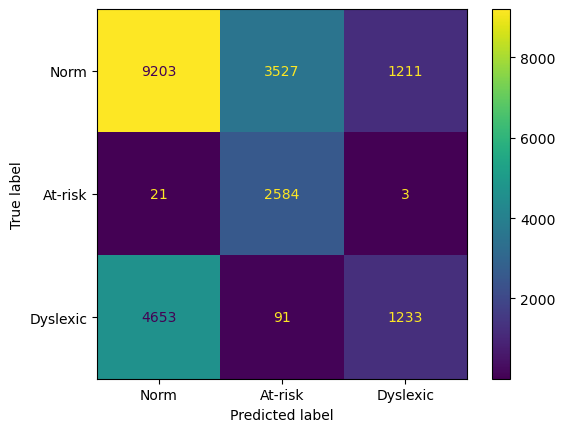

Kappa: 0.24377917961295814 AUC ROC: 0.7202430041239942


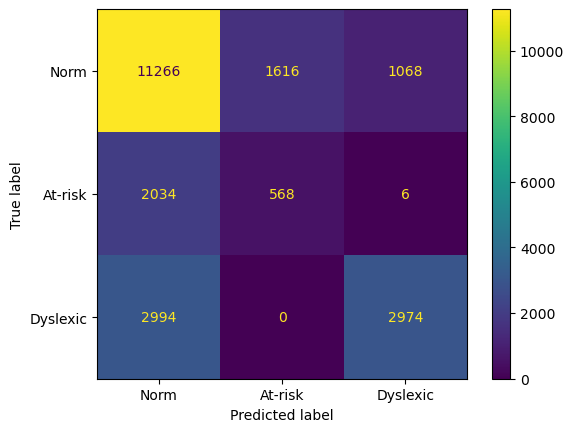

Kappa: 0.30531380651488516 AUC ROC: 0.6348527010670904
  ari    nmi  	 preci 	 recall  	 f1_score  	 roc_auc  	 meape  	 jsd  	 acc 	 tnr
 Ave   std  Ave   std   Ave   std   Ave   std   Ave   std   Ave   std   Ave   std   Ave   std   Ave   std   Ave   std 
0.247 0.166 0.232 0.124 0.668 0.112 0.671 0.108 0.660 0.111 0.733 0.127 17.654 0.214 0.521 0.103 0.671 0.108 0.693 0.110


In [33]:




res = load_a_dict(
    name=configs.specifier + "_n_epochs=" + str(50),
    save_path=configs.results_path
        )

print_results_per_epochs(res)




## N_epochs = 100



In [ ]:

data = dd.get_stratified_train_test_splits(
    x=x, y=y,
    labels=y_org.Group.values,
    to_shuffle=False,
    n_splits=10
)



results = {}
n_epochs = 100



for k, v in data.items():
    
    results[k] = {}
    
    # create the models
    n_filters = 32
    kernel_size = 3
    max_pooling_size = 2
    n_outputs = 3
    n_steps = 10

    
    # create the models
    n_filters = 32
    kernel_size = 3
    max_pooling_size = 2
    n_outputs = 3
    n_steps = 10

    

    # define two sets of inputs
    input_demo = tfkl.Input(shape=(10,), name="demographic_input")
    input_fix = tfkl.Input(shape=(n_steps, 3), name="fixation_input")

    # MLP for demographic: the first model operates on the first input:
    a = tfkl.Dense(173, activation="linear", name="demographic_h1")(input_demo)
    a = tfk.Model(inputs=input_demo, outputs=a)


    # CNN for fixation: the second model opreates on the second input
    b = tfkl.Conv1D(filters=n_filters,
               kernel_size=kernel_size,  
               activation="relu",  
               input_shape=(n_steps, 3),  # three fixation features
               name="fixation_conv1")(input_fix)


    b = tfkl.Conv1D(filters=n_filters, 
               kernel_size=kernel_size, 
               activation="relu", 
               name="fixation_conv2",)(b)

    b = tfkl.Dropout(0.1, name="fixation_drop1")(b)
    b = tfkl.MaxPool1D(max_pooling_size, name="fixation_max_pool1")(b)
    b = tfkl.Flatten(name="fixation_flatten1")(b)
    b = tfkl.Dense(units=192, activation='relu', name="fixation_dense1")(b)
    # b = tfkl.Dense(units=n_outputs, activation="softmax", 
    # name="fixation_out")(b)
    b = tfk.Model(inputs=input_fix, outputs=b)


    # combine the output of the two models
    combined = tfkl.concatenate([a.output, b.output], name="concat_demo_fix")

    # apply a FC layer and then a softmax to predict the classes on the combined outputs
    c = tfkl.Dense(100, activation="relu", name="dense_concat1")(combined)
    c = tfkl.Dense(3, activation="softmax", name="class_pred")(c)

    # our model will accept the inputs of the two models and then output a class labels
    mlp_cnn_mdl = tfk.Model(inputs=[a.input, b.input], outputs=c, 
                            name="combined_demo_fix")
    
    

    # prepare data
    xx = np.asarray(v["x_train"]).astype('float32')
    yy = v["y_train"]
    xx_t = np.asarray(v["x_test"]).astype('float32')
    yy_t = v["y_test"]
    
    xx_ , yy_ = split_sequences(xx[:, :3], yy, n_steps=10)
    xx_t_ , yy_t_ = split_sequences(xx_t[:, :3], yy_t, n_steps=10)
    
    _yy = np.subtract(yy, 1, dtype=np.int8)
    _yy_t = np.subtract(yy_t, 1, dtype=np.int8)

    start = time.time()
    
    mlp_cnn_mdl.compile(
            loss="sparse_categorical_crossentropy",
            optimizer=tfk.optimizers.Adam(learning_rate=0.0001), 
            metrics=["accuracy"],
        )
    
    mlp_cnn_mdl.fit(x=[xx[:xx_.shape[0], 3:], xx_,], y=_yy[:xx_.shape[0]],
                   epochs=n_epochs, 
                  )
    
    yy_pred_ = mlp_cnn_mdl.predict([xx_t[:xx_t_.shape[0], 3:], xx_t_,])  # xx_t_
   
    
    end = time.time()
    
    results[k]["x_test"] =xx_t_
    results[k]["y_test"] = _yy_t[:xx_t_.shape[0]]
    results[k]["y_pred"] = yy_pred_.argmax(axis=1)
    results[k]["y_pred_prob"] = yy_pred_
    results[k]["exe_time"] = end - start
    

save_a_dict(
    a_dict=results,
    name=configs.specifier + "_n_epochs=" + str(n_epochs),
    save_path=configs.results_path,
)


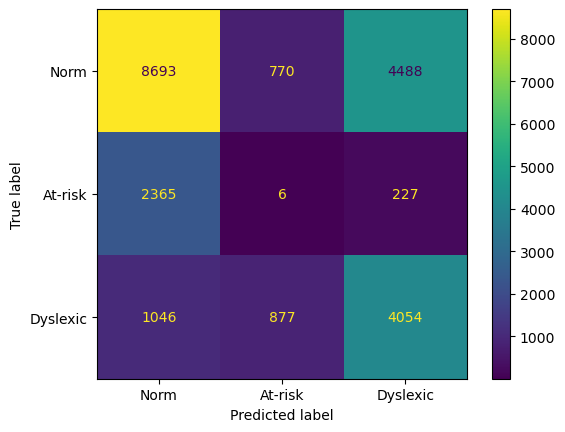

Kappa: 0.21892551263750326 AUC ROC: 0.6129610335937592


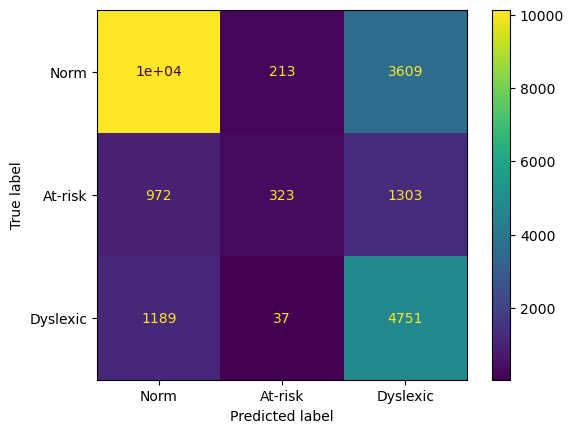

Kappa: 0.40387827584237135 AUC ROC: 0.7932214820393956


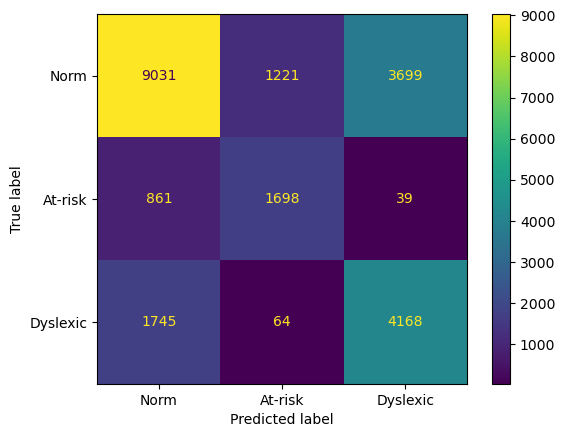

Kappa: 0.4075515915455299 AUC ROC: 0.7658391920452985


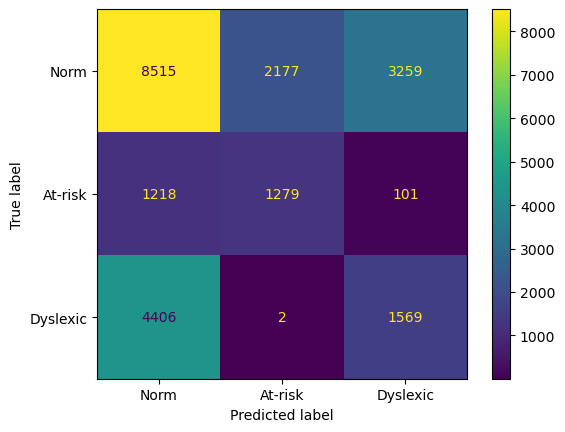

Kappa: 0.07458048909151849 AUC ROC: 0.4243150946125401


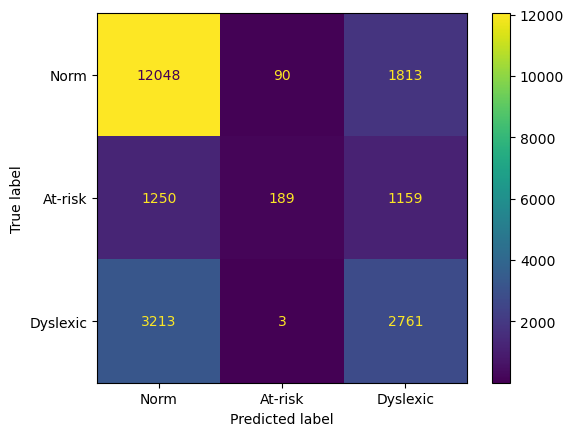

Kappa: 0.29949655923027263 AUC ROC: 0.677388640613671


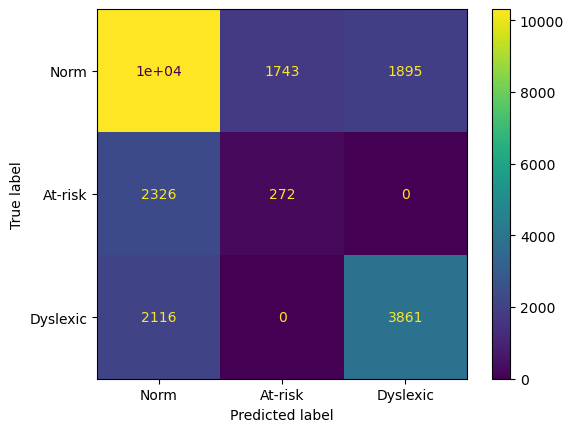

Kappa: 0.3051328835137471 AUC ROC: 0.641330765324435


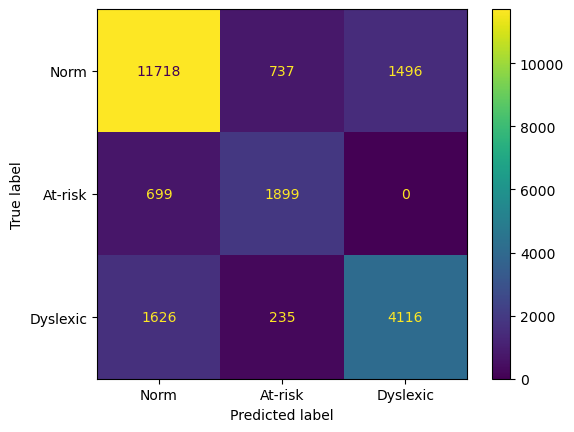

Kappa: 0.6008683107489019 AUC ROC: 0.9059677607451048


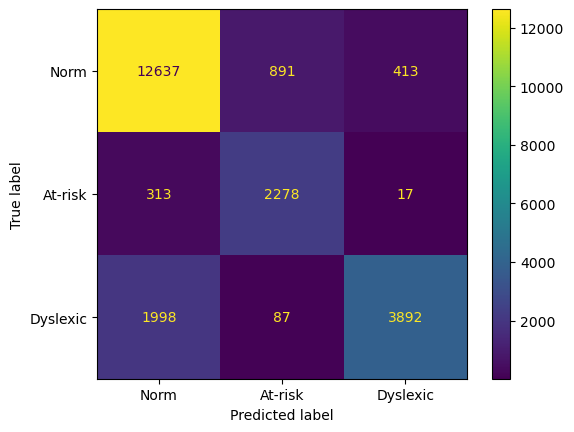

Kappa: 0.6835202897991505 AUC ROC: 0.8618867986721076


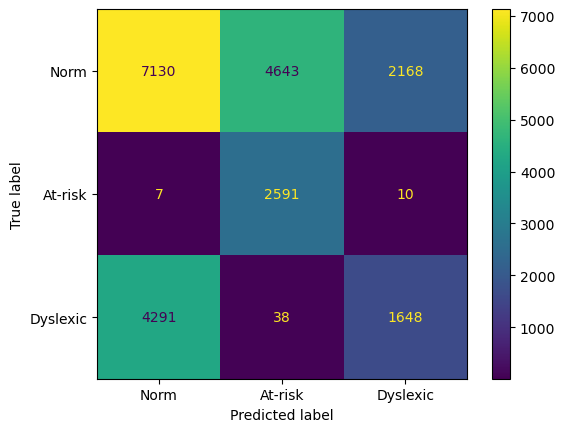

Kappa: 0.17940721824941464 AUC ROC: 0.6711870359077635


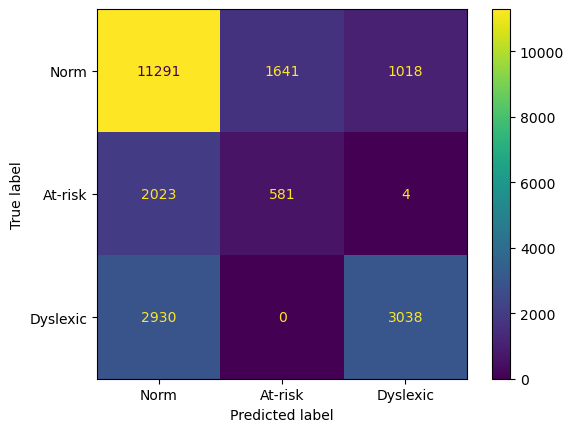

Kappa: 0.31593456277800447 AUC ROC: 0.6759368592021423


NameError: name 'learning_method' is not defined

In [16]:




res = load_a_dict(
    name=configs.specifier + "_n_epochs=" + str(100),
    save_path=configs.results_path
        )

print_results_per_epochs(res)




## N_epochs = 200



In [34]:

data = dd.get_stratified_train_test_splits(
    x=x, y=y,
    labels=y_org.Group.values,
    to_shuffle=False,
    n_splits=10
)



results = {}
n_epochs = 200



for k, v in data.items():
    
    results[k] = {}
    
    # create the models
    n_filters = 32
    kernel_size = 3
    max_pooling_size = 2
    n_outputs = 3
    n_steps = 10

    
    # create the models
    n_filters = 32
    kernel_size = 3
    max_pooling_size = 2
    n_outputs = 3
    n_steps = 10

    

    # define two sets of inputs
    input_demo = tfkl.Input(shape=(10,), name="demographic_input")
    input_fix = tfkl.Input(shape=(n_steps, 3), name="fixation_input")

    # MLP for demographic: the first model operates on the first input:
    a = tfkl.Dense(173, activation="linear", name="demographic_h1")(input_demo)
    a = tfk.Model(inputs=input_demo, outputs=a)


    # CNN for fixation: the second model opreates on the second input
    b = tfkl.Conv1D(filters=n_filters,
               kernel_size=kernel_size,  
               activation="relu",  
               input_shape=(n_steps, 3),  # three fixation features
               name="fixation_conv1")(input_fix)


    b = tfkl.Conv1D(filters=n_filters, 
               kernel_size=kernel_size, 
               activation="relu", 
               name="fixation_conv2",)(b)

    b = tfkl.Dropout(0.1, name="fixation_drop1")(b)
    b = tfkl.MaxPool1D(max_pooling_size, name="fixation_max_pool1")(b)
    b = tfkl.Flatten(name="fixation_flatten1")(b)
    b = tfkl.Dense(units=192, activation='relu', name="fixation_dense1")(b)
    # b = tfkl.Dense(units=n_outputs, activation="softmax", 
    # name="fixation_out")(b)
    b = tfk.Model(inputs=input_fix, outputs=b)


    # combine the output of the two models
    combined = tfkl.concatenate([a.output, b.output], name="concat_demo_fix")

    # apply a FC layer and then a softmax to predict the classes on the combined outputs
    c = tfkl.Dense(100, activation="relu", name="dense_concat1")(combined)
    c = tfkl.Dense(3, activation="softmax", name="class_pred")(c)

    # our model will accept the inputs of the two models and then output a class labels
    mlp_cnn_mdl = tfk.Model(inputs=[a.input, b.input], outputs=c, 
                            name="combined_demo_fix")
    
    

    # prepare data
    xx = np.asarray(v["x_train"]).astype('float32')
    yy = v["y_train"]
    xx_t = np.asarray(v["x_test"]).astype('float32')
    yy_t = v["y_test"]
    
    xx_ , yy_ = split_sequences(xx[:, :3], yy, n_steps=10)
    xx_t_ , yy_t_ = split_sequences(xx_t[:, :3], yy_t, n_steps=10)
    
    _yy = np.subtract(yy, 1, dtype=np.int8)
    _yy_t = np.subtract(yy_t, 1, dtype=np.int8)

    start = time.time()
    
    mlp_cnn_mdl.compile(
            loss="sparse_categorical_crossentropy",
            optimizer=tfk.optimizers.Adam(learning_rate=0.0001), 
            metrics=["accuracy"],
        )
    
    mlp_cnn_mdl.fit(x=[xx[:xx_.shape[0], 3:], xx_,], y=_yy[:xx_.shape[0]],
                   epochs=n_epochs, 
                  )
    
    yy_pred_ = mlp_cnn_mdl.predict([xx_t[:xx_t_.shape[0], 3:], xx_t_,])  # xx_t_
   
    
    end = time.time()
    
    results[k]["x_test"] =xx_t_
    results[k]["y_test"] = _yy_t[:xx_t_.shape[0]]
    results[k]["y_pred"] = yy_pred_.argmax(axis=1)
    results[k]["y_pred_prob"] = yy_pred_
    results[k]["exe_time"] = end - start
    

save_a_dict(
    a_dict=results,
    name=configs.specifier + "_n_epochs=" + str(n_epochs),
    save_path=configs.results_path,
)


Epoch 1/200
6338/6338 [==============================] - 8s 1ms/step - loss: 0.6306 - accuracy: 0.7247
Epoch 2/200
6338/6338 [==============================] - 12s 2ms/step - loss: 0.5200 - accuracy: 0.7838
Epoch 3/200
6338/6338 [==============================] - 7s 1ms/step - loss: 0.4581 - accuracy: 0.8099
Epoch 4/200
6338/6338 [==============================] - 12s 2ms/step - loss: 0.4104 - accuracy: 0.8302
Epoch 5/200
6338/6338 [==============================] - 9s 1ms/step - loss: 0.3735 - accuracy: 0.8465
Epoch 6/200
6338/6338 [==============================] - 9s 1ms/step - loss: 0.3454 - accuracy: 0.8566
Epoch 7/200
6338/6338 [==============================] - 12s 2ms/step - loss: 0.3231 - accuracy: 0.8658
Epoch 8/200
6338/6338 [==============================] - 6s 999us/step - loss: 0.3048 - accuracy: 0.8728
Epoch 9/200
6338/6338 [==============================] - 12s 2ms/step - loss: 0.2880 - accuracy: 0.8802
Epoch 10/200
6338/6338 [==============================] - 6s 1ms/st

6338/6338 [==============================] - 7s 1ms/step - loss: 0.0396 - accuracy: 0.9850
Epoch 157/200
6338/6338 [==============================] - 12s 2ms/step - loss: 0.0394 - accuracy: 0.9852
Epoch 158/200
6338/6338 [==============================] - 6s 1ms/step - loss: 0.0396 - accuracy: 0.9849
Epoch 159/200
6338/6338 [==============================] - 12s 2ms/step - loss: 0.0392 - accuracy: 0.9853
Epoch 160/200
6338/6338 [==============================] - 6s 1ms/step - loss: 0.0384 - accuracy: 0.9854
Epoch 161/200
6338/6338 [==============================] - 12s 2ms/step - loss: 0.0385 - accuracy: 0.9855
Epoch 162/200
6338/6338 [==============================] - 12s 2ms/step - loss: 0.0386 - accuracy: 0.9857
Epoch 163/200
6338/6338 [==============================] - 6s 1ms/step - loss: 0.0377 - accuracy: 0.9860
Epoch 164/200
6338/6338 [==============================] - 12s 2ms/step - loss: 0.0376 - accuracy: 0.9859
Epoch 165/200
6338/6338 [==============================] - 6s 99

6338/6338 [==============================] - 7s 1ms/step - loss: 0.1430 - accuracy: 0.9455
Epoch 35/200
6338/6338 [==============================] - 12s 2ms/step - loss: 0.1403 - accuracy: 0.9463
Epoch 36/200
6338/6338 [==============================] - 6s 1ms/step - loss: 0.1374 - accuracy: 0.9478
Epoch 37/200
6338/6338 [==============================] - 12s 2ms/step - loss: 0.1356 - accuracy: 0.9483
Epoch 38/200
6338/6338 [==============================] - 6s 1ms/step - loss: 0.1329 - accuracy: 0.9498
Epoch 39/200
6338/6338 [==============================] - 12s 2ms/step - loss: 0.1312 - accuracy: 0.9502
Epoch 40/200
6338/6338 [==============================] - 11s 2ms/step - loss: 0.1288 - accuracy: 0.9513
Epoch 41/200
6338/6338 [==============================] - 7s 1ms/step - loss: 0.1265 - accuracy: 0.9523
Epoch 42/200
6338/6338 [==============================] - 13s 2ms/step - loss: 0.1252 - accuracy: 0.9525
Epoch 43/200
6338/6338 [==============================] - 7s 1ms/step - 

6338/6338 [==============================] - 8s 1ms/step - loss: 0.0389 - accuracy: 0.9853
Epoch 190/200
6338/6338 [==============================] - 11s 2ms/step - loss: 0.0385 - accuracy: 0.9855
Epoch 191/200
6338/6338 [==============================] - 12s 2ms/step - loss: 0.0387 - accuracy: 0.9854
Epoch 192/200
6338/6338 [==============================] - 6s 1ms/step - loss: 0.0387 - accuracy: 0.9857
Epoch 193/200
6338/6338 [==============================] - 12s 2ms/step - loss: 0.0378 - accuracy: 0.9861
Epoch 194/200
6338/6338 [==============================] - 6s 1ms/step - loss: 0.0375 - accuracy: 0.9859
Epoch 195/200
6338/6338 [==============================] - 12s 2ms/step - loss: 0.0378 - accuracy: 0.9858
Epoch 196/200
6338/6338 [==============================] - 12s 2ms/step - loss: 0.0370 - accuracy: 0.9862
Epoch 197/200
6338/6338 [==============================] - 6s 1ms/step - loss: 0.0367 - accuracy: 0.9864
Epoch 198/200
6338/6338 [==============================] - 12s 2

Epoch 145/200
6338/6338 [==============================] - 6s 1ms/step - loss: 0.0353 - accuracy: 0.9868
Epoch 146/200
6338/6338 [==============================] - 12s 2ms/step - loss: 0.0350 - accuracy: 0.9871
Epoch 147/200
6338/6338 [==============================] - 9s 1ms/step - loss: 0.0357 - accuracy: 0.9869
Epoch 148/200
6338/6338 [==============================] - 9s 1ms/step - loss: 0.0345 - accuracy: 0.9877
Epoch 149/200
6338/6338 [==============================] - 12s 2ms/step - loss: 0.0344 - accuracy: 0.9873
Epoch 150/200
6338/6338 [==============================] - 7s 1ms/step - loss: 0.0344 - accuracy: 0.9876
Epoch 151/200
6338/6338 [==============================] - 12s 2ms/step - loss: 0.0341 - accuracy: 0.9875
Epoch 152/200
6338/6338 [==============================] - 6s 1ms/step - loss: 0.0334 - accuracy: 0.9878
Epoch 153/200
6338/6338 [==============================] - 12s 2ms/step - loss: 0.0332 - accuracy: 0.9877
Epoch 154/200
6338/6338 [==========================

6338/6338 [==============================] - 7s 1ms/step - loss: 0.0635 - accuracy: 0.9755
Epoch 101/200
6338/6338 [==============================] - 12s 2ms/step - loss: 0.0631 - accuracy: 0.9756
Epoch 102/200
6338/6338 [==============================] - 12s 2ms/step - loss: 0.0620 - accuracy: 0.9762
Epoch 103/200
6338/6338 [==============================] - 6s 1ms/step - loss: 0.0618 - accuracy: 0.9760
Epoch 104/200
6338/6338 [==============================] - 12s 2ms/step - loss: 0.0617 - accuracy: 0.9762
Epoch 105/200
6338/6338 [==============================] - 6s 1ms/step - loss: 0.0611 - accuracy: 0.9762
Epoch 106/200
6338/6338 [==============================] - 12s 2ms/step - loss: 0.0601 - accuracy: 0.9770
Epoch 107/200
6338/6338 [==============================] - 12s 2ms/step - loss: 0.0608 - accuracy: 0.9764
Epoch 108/200
6338/6338 [==============================] - 7s 1ms/step - loss: 0.0595 - accuracy: 0.9770
Epoch 109/200
6338/6338 [==============================] - 12s 2

6338/6338 [==============================] - 10s 2ms/step - loss: 0.0921 - accuracy: 0.9650
Epoch 56/200
6338/6338 [==============================] - 8s 1ms/step - loss: 0.0907 - accuracy: 0.9659
Epoch 57/200
6338/6338 [==============================] - 12s 2ms/step - loss: 0.0896 - accuracy: 0.9663
Epoch 58/200
6338/6338 [==============================] - 6s 1ms/step - loss: 0.0885 - accuracy: 0.9670
Epoch 59/200
6338/6338 [==============================] - 12s 2ms/step - loss: 0.0878 - accuracy: 0.9666
Epoch 60/200
6338/6338 [==============================] - 6s 1ms/step - loss: 0.0863 - accuracy: 0.9676
Epoch 61/200
6338/6338 [==============================] - 12s 2ms/step - loss: 0.0854 - accuracy: 0.9674
Epoch 62/200
6338/6338 [==============================] - 12s 2ms/step - loss: 0.0839 - accuracy: 0.9682
Epoch 63/200
6338/6338 [==============================] - 8s 1ms/step - loss: 0.0834 - accuracy: 0.9682
Epoch 64/200
6338/6338 [==============================] - 12s 2ms/step -

6338/6338 [==============================] - 6s 1ms/step - loss: 0.0461 - accuracy: 0.9826
Epoch 134/200
6338/6338 [==============================] - 12s 2ms/step - loss: 0.0456 - accuracy: 0.9825
Epoch 135/200
6338/6338 [==============================] - 6s 1ms/step - loss: 0.0458 - accuracy: 0.9828
Epoch 136/200
6338/6338 [==============================] - 12s 2ms/step - loss: 0.0453 - accuracy: 0.9828
Epoch 137/200
6338/6338 [==============================] - 12s 2ms/step - loss: 0.0446 - accuracy: 0.9833
Epoch 138/200
6338/6338 [==============================] - 7s 1ms/step - loss: 0.0447 - accuracy: 0.9831
Epoch 139/200
6338/6338 [==============================] - 12s 2ms/step - loss: 0.0447 - accuracy: 0.9830
Epoch 140/200
6338/6338 [==============================] - 6s 1ms/step - loss: 0.0441 - accuracy: 0.9833
Epoch 141/200
6338/6338 [==============================] - 12s 2ms/step - loss: 0.0436 - accuracy: 0.9836
Epoch 142/200
6338/6338 [==============================] - 11s 2

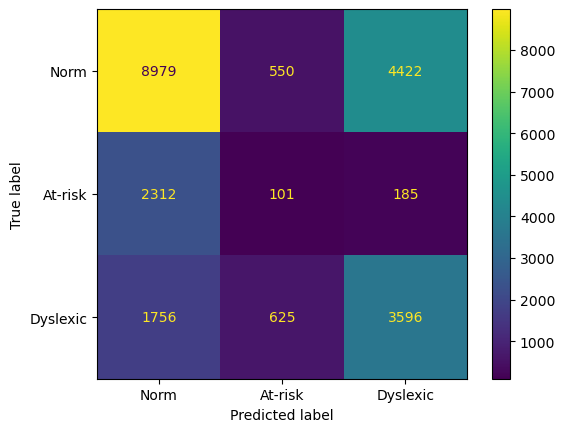

Kappa: 0.18742016336479927 AUC ROC: 0.6063114474906962


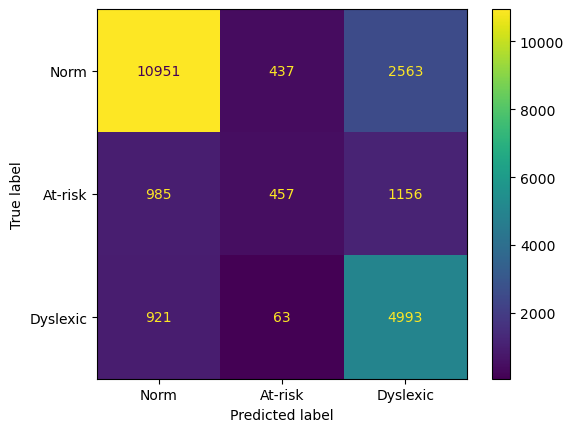

Kappa: 0.4955232396244932 AUC ROC: 0.8154668500082067


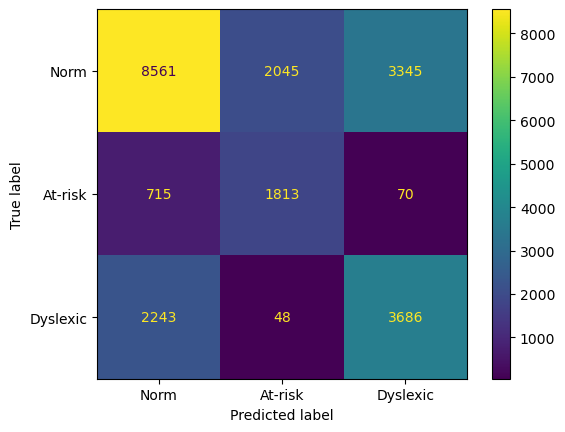

Kappa: 0.35162684360403085 AUC ROC: 0.6917829155107581


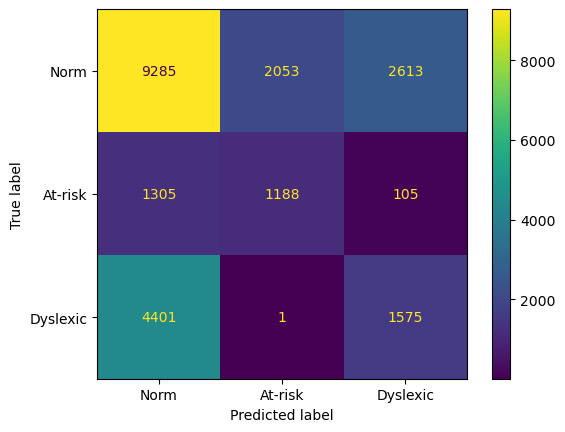

Kappa: 0.1066309959129409 AUC ROC: 0.46211077460193506


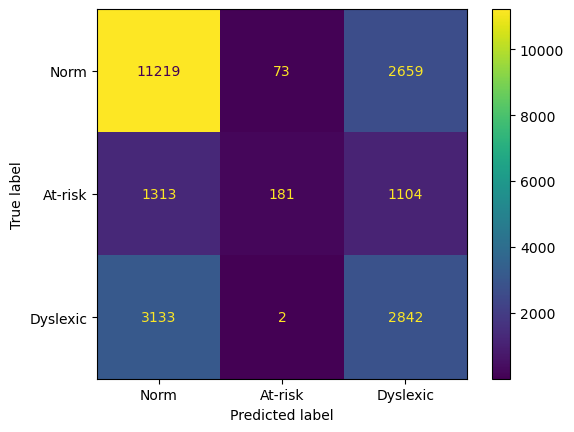

Kappa: 0.24978262817508068 AUC ROC: 0.6284587994189036


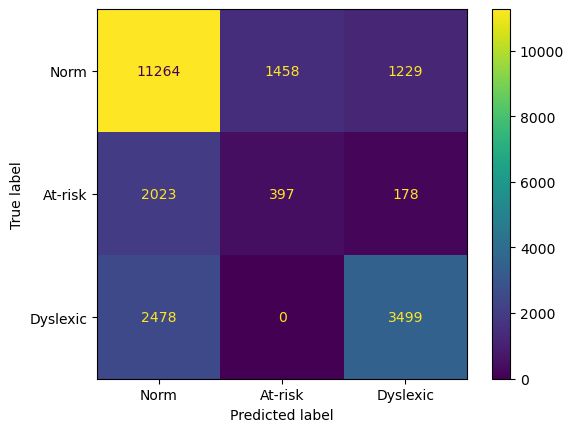

Kappa: 0.3450459791679197 AUC ROC: 0.6987053160269694


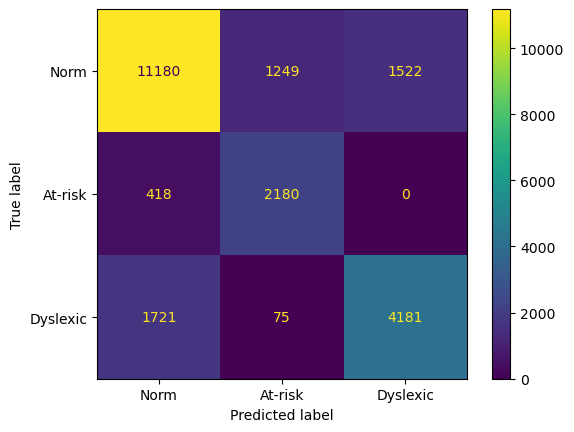

Kappa: 0.5966766536496015 AUC ROC: 0.8790576777223901


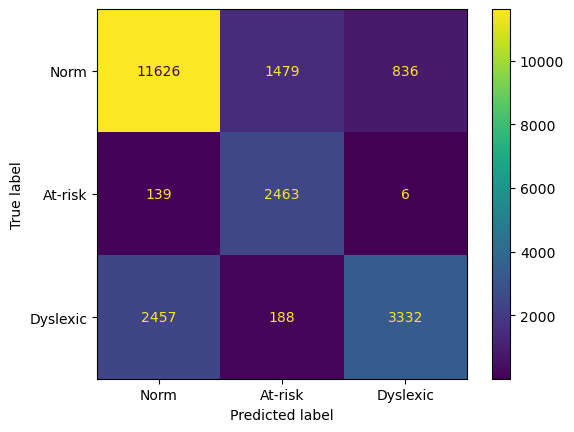

Kappa: 0.579438688716482 AUC ROC: 0.8363825315014853


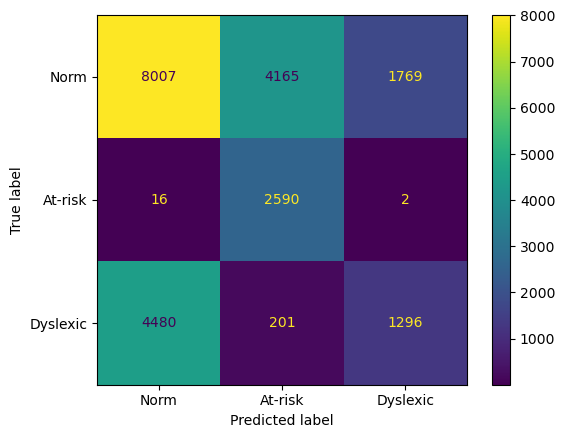

Kappa: 0.19257007109466295 AUC ROC: 0.6691195003960894


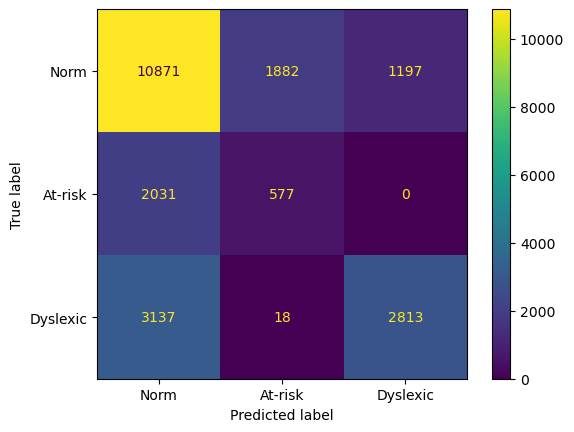

Kappa: 0.26494880686347977 AUC ROC: 0.6658062932796138


NameError: name 'learning_method' is not defined

In [17]:

res = load_a_dict(
    name=configs.specifier + "_n_epochs=" + str(200),
    save_path=configs.results_path
        )

print_results_per_epochs(res)



## N_epochs = 500

In [ ]:



data = dd.get_stratified_train_test_splits(
    x=x, y=y,
    labels=y_org.Group.values,
    to_shuffle=False,
    n_splits=10
)



results = {}
n_epochs = 500



for k, v in data.items():
    
    results[k] = {}
    
    # create the models
    n_filters = 32
    kernel_size = 3
    max_pooling_size = 2
    n_outputs = 3
    n_steps = 10

    
    # create the models
    n_filters = 32
    kernel_size = 3
    max_pooling_size = 2
    n_outputs = 3
    n_steps = 10

    

    # define two sets of inputs
    input_demo = tfkl.Input(shape=(10,), name="demographic_input")
    input_fix = tfkl.Input(shape=(n_steps, 3), name="fixation_input")

    # MLP for demographic: the first model operates on the first input:
    a = tfkl.Dense(173, activation="linear", name="demographic_h1")(input_demo)
    a = tfk.Model(inputs=input_demo, outputs=a)


    # CNN for fixation: the second model opreates on the second input
    b = tfkl.Conv1D(filters=n_filters,
               kernel_size=kernel_size,  
               activation="relu",  
               input_shape=(n_steps, 3),  # three fixation features
               name="fixation_conv1")(input_fix)


    b = tfkl.Conv1D(filters=n_filters, 
               kernel_size=kernel_size, 
               activation="relu", 
               name="fixation_conv2",)(b)

    b = tfkl.Dropout(0.1, name="fixation_drop1")(b)
    b = tfkl.MaxPool1D(max_pooling_size, name="fixation_max_pool1")(b)
    b = tfkl.Flatten(name="fixation_flatten1")(b)
    b = tfkl.Dense(units=192, activation='relu', name="fixation_dense1")(b)
    # b = tfkl.Dense(units=n_outputs, activation="softmax", 
    # name="fixation_out")(b)
    b = tfk.Model(inputs=input_fix, outputs=b)


    # combine the output of the two models
    combined = tfkl.concatenate([a.output, b.output], name="concat_demo_fix")

    # apply a FC layer and then a softmax to predict the classes on the combined outputs
    c = tfkl.Dense(100, activation="relu", name="dense_concat1")(combined)
    c = tfkl.Dense(3, activation="softmax", name="class_pred")(c)

    # our model will accept the inputs of the two models and then output a class labels
    mlp_cnn_mdl = tfk.Model(inputs=[a.input, b.input], outputs=c, 
                            name="combined_demo_fix")
    
    

    # prepare data
    xx = np.asarray(v["x_train"]).astype('float32')
    yy = v["y_train"]
    xx_t = np.asarray(v["x_test"]).astype('float32')
    yy_t = v["y_test"]
    
    xx_ , yy_ = split_sequences(xx[:, :3], yy, n_steps=10)
    xx_t_ , yy_t_ = split_sequences(xx_t[:, :3], yy_t, n_steps=10)
    
    _yy = np.subtract(yy, 1, dtype=np.int8)
    _yy_t = np.subtract(yy_t, 1, dtype=np.int8)

    start = time.time()
    
    mlp_cnn_mdl.compile(
            loss="sparse_categorical_crossentropy",
            optimizer=tfk.optimizers.Adam(learning_rate=0.0001), 
            metrics=["accuracy"],
        )
    
    mlp_cnn_mdl.fit(x=[xx[:xx_.shape[0], 3:], xx_,], y=_yy[:xx_.shape[0]],
                   epochs=n_epochs, 
                  )
    
    yy_pred_ = mlp_cnn_mdl.predict([xx_t[:xx_t_.shape[0], 3:], xx_t_,])  # xx_t_
   
    
    end = time.time()
    
    results[k]["x_test"] =xx_t_
    results[k]["y_test"] = _yy_t[:xx_t_.shape[0]]
    results[k]["y_pred"] = yy_pred_.argmax(axis=1)
    results[k]["y_pred_prob"] = yy_pred_
    results[k]["exe_time"] = end - start
    

save_a_dict(
    a_dict=results,
    name=configs.specifier + "_n_epochs=" + str(n_epochs),
    save_path=configs.results_path,
)


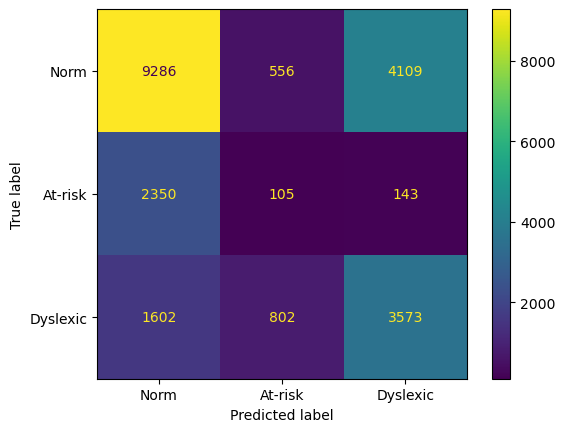

Kappa: 0.20859598710478777 AUC ROC: 0.6096640449765224


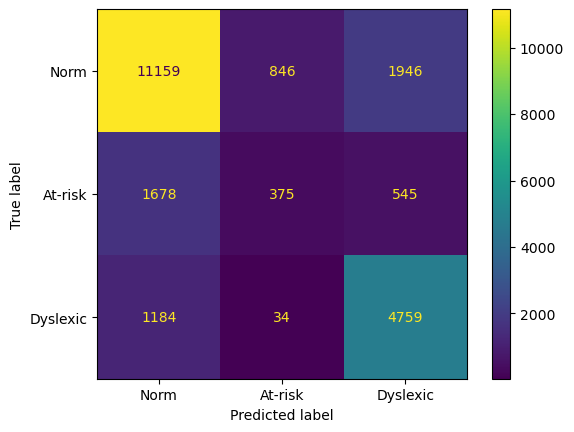

Kappa: 0.47061090216190926 AUC ROC: 0.8054544724634386


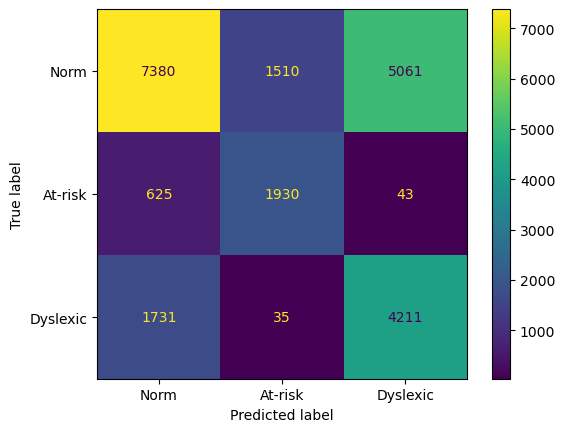

Kappa: 0.339024820087371 AUC ROC: 0.6859786862765969


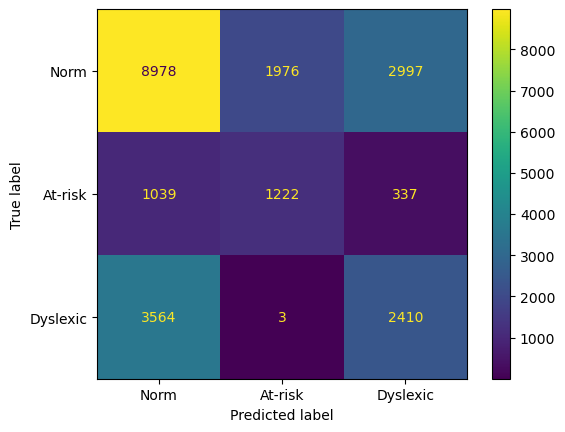

Kappa: 0.18865048044932742 AUC ROC: 0.5859133735513509


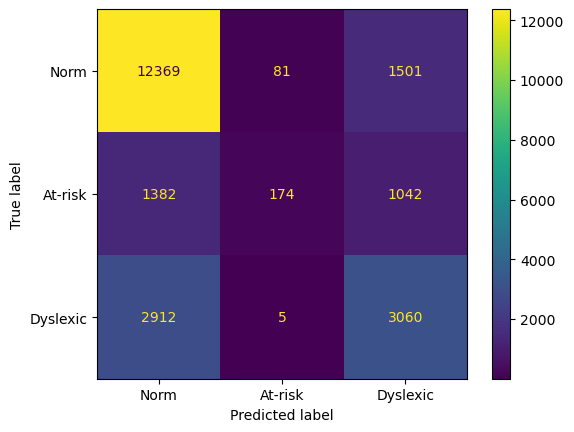

Kappa: 0.35235208896402204 AUC ROC: 0.6702536660849583


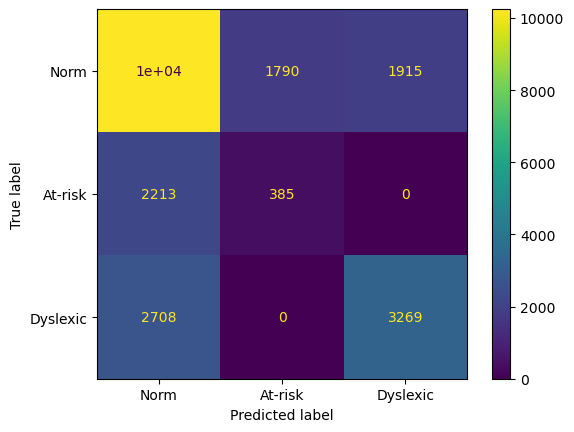

Kappa: 0.25032236817715037 AUC ROC: 0.6272151770674314


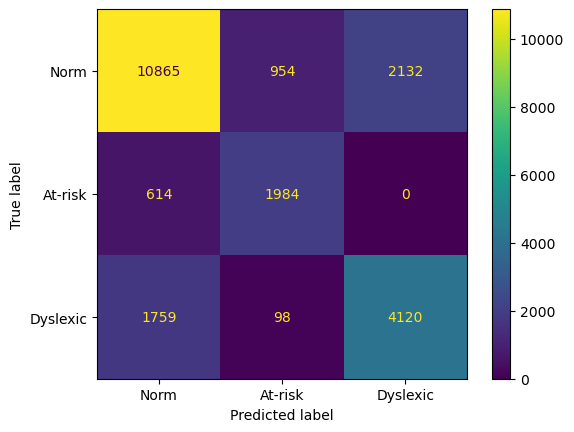

Kappa: 0.5488818743538626 AUC ROC: 0.8660244214845914


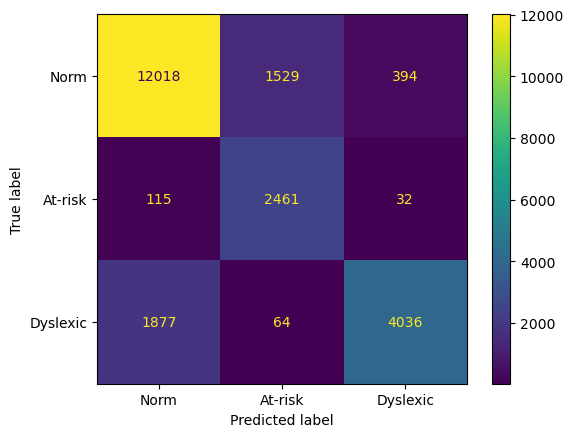

Kappa: 0.6712867543077319 AUC ROC: 0.8769042698752717


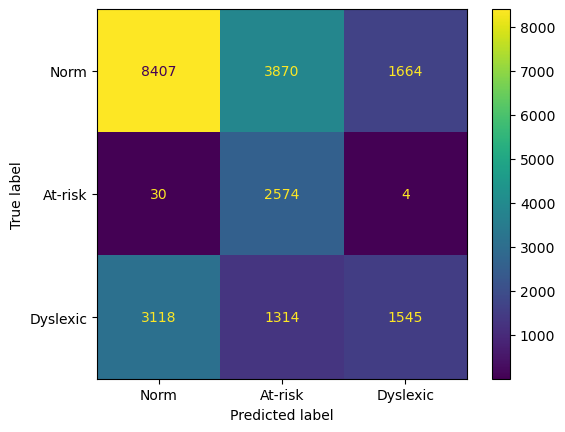

Kappa: 0.2660041209603312 AUC ROC: 0.7215235658267232


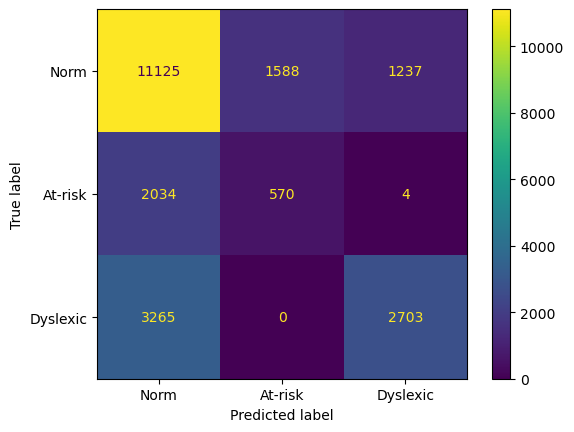

Kappa: 0.26510671388723495 AUC ROC: 0.6210147861499132


NameError: name 'learning_method' is not defined

In [18]:




res = load_a_dict(
    name=configs.specifier + "_n_epochs=" + str(500),
    save_path=configs.results_path
        )

print_results_per_epochs(res)



In [36]:





data = dd.get_stratified_train_test_splits(
    x=x, y=y,
    labels=y_org.Group.values,
    to_shuffle=False,
    n_splits=10
)



results = {}
n_epochs = 2000



for k, v in data.items():
    
    results[k] = {}
    
    # create the models
    n_filters = 32
    kernel_size = 3
    max_pooling_size = 2
    n_outputs = 3
    n_steps = 10


    # define two sets of inputs
    input_demo = tfkl.Input(shape=(10,), name="demographic_input")
    input_fix = tfkl.Input(shape=(n_steps, 3), name="fixation_input")

    # MLP for demographic: the first model operates on the first input:
    a = tfkl.Dense(173, activation="linear", name="demographic_h1")(input_demo)
    a = tfk.Model(inputs=input_demo, outputs=a)


    # CNN for fixation: the second model opreates on the second input
    b = tfkl.Conv1D(filters=n_filters,
               kernel_size=kernel_size,  
               activation="relu",  
               input_shape=(n_steps, 3),  # three fixation features
               name="fixation_conv1")(input_fix)


    b = tfkl.Conv1D(filters=n_filters, 
               kernel_size=kernel_size, 
               activation="relu", 
               name="fixation_conv2",)(b)

    b = tfkl.Dropout(0.1, name="fixation_drop1")(b)
    b = tfkl.MaxPool1D(max_pooling_size, name="fixation_max_pool1")(b)
    b = tfkl.Flatten(name="fixation_flatten1")(b)
    b = tfkl.Dense(units=192, activation='relu', name="fixation_dense1")(b)
    # b = tfkl.Dense(units=n_outputs, activation="softmax", 
    # name="fixation_out")(b)
    b = tfk.Model(inputs=input_fix, outputs=b)


    # combine the output of the two models
    combined = tfkl.concatenate([a.output, b.output], name="concat_demo_fix")

    # apply a FC layer and then a softmax to predict the classes on the combined outputs
    c = tfkl.Dense(100, activation="relu", name="dense_concat1")(combined)
    c = tfkl.Dense(3, activation="softmax", name="class_pred")(c)

    # our model will accept the inputs of the two models and then output a class labels
    mlp_cnn_mdl = tfk.Model(inputs=[a.input, b.input], outputs=c, 
                            name="combined_demo_fix")
    
    

    # prepare data
    xx = np.asarray(v["x_train"]).astype('float32')
    yy = v["y_train"]
    xx_t = np.asarray(v["x_test"]).astype('float32')
    yy_t = v["y_test"]
    
    xx_ , yy_ = split_sequences(xx[:, :3], yy, n_steps=10)
    xx_t_ , yy_t_ = split_sequences(xx_t[:, :3], yy_t, n_steps=10)
    
    _yy = np.subtract(yy, 1, dtype=np.int8)
    _yy_t = np.subtract(yy_t, 1, dtype=np.int8)

    start = time.time()
    
    mlp_cnn_mdl.compile(
            loss="sparse_categorical_crossentropy",
            optimizer=tfk.optimizers.Adam(learning_rate=0.0001), 
            metrics=["accuracy"],
        )
    
    mlp_cnn_mdl.fit(x=[xx[:xx_.shape[0], 3:], xx_,], y=_yy[:xx_.shape[0]],
                   epochs=n_epochs, 
                  )
    
    yy_pred_ = mlp_cnn_mdl.predict([xx_t[:xx_t_.shape[0], 3:], xx_t_,])  # xx_t_
   
    
    end = time.time()
    
    results[k]["x_test"] =xx_t_
    results[k]["y_test"] = _yy_t[:xx_t_.shape[0]]
    results[k]["y_pred"] = yy_pred_.argmax(axis=1)
    results[k]["y_pred_prob"] = yy_pred_
    results[k]["exe_time"] = end - start
    

save_a_dict(
    a_dict=results,
    name=configs.specifier + "_n_epochs=" + str(n_epochs),
    save_path=configs.results_path,
)





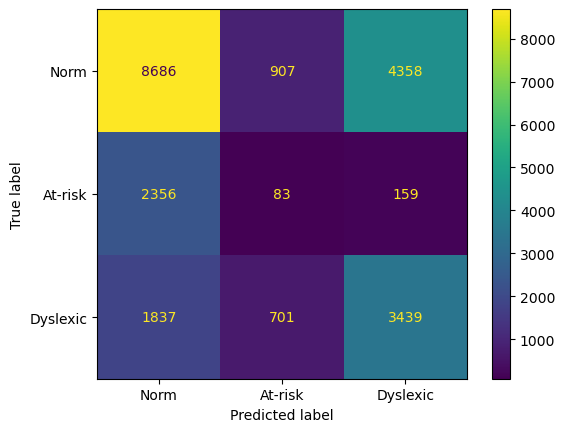

Kappa: 0.15727456477017698 AUC ROC: 0.6110940307546037


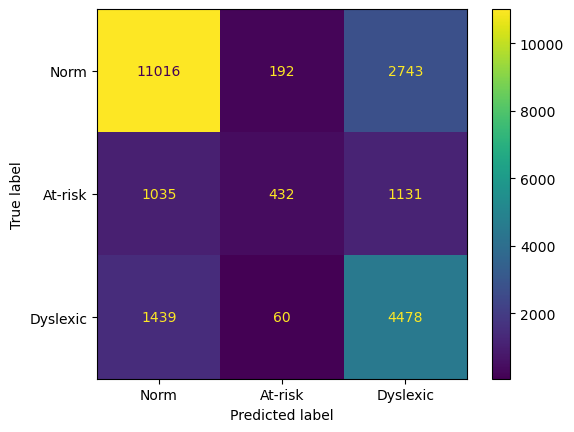

Kappa: 0.44426973579080065 AUC ROC: 0.7812128396762128


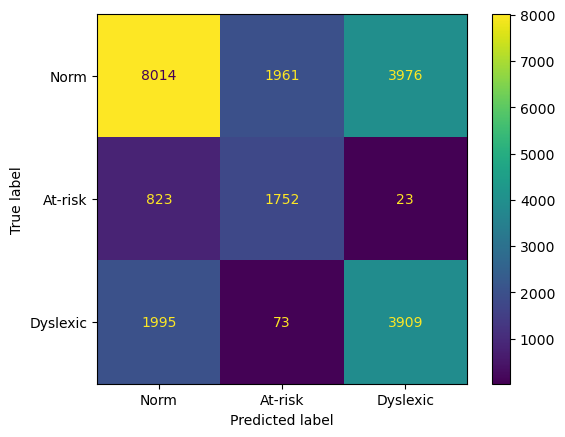

Kappa: 0.3336338244519659 AUC ROC: 0.715707644316149


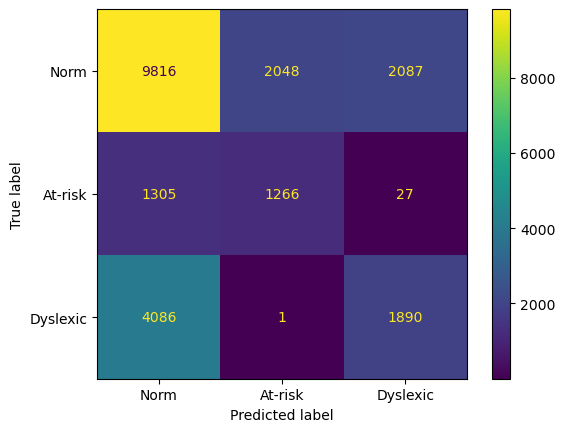

Kappa: 0.1808370000615971 AUC ROC: 0.5633931791610183


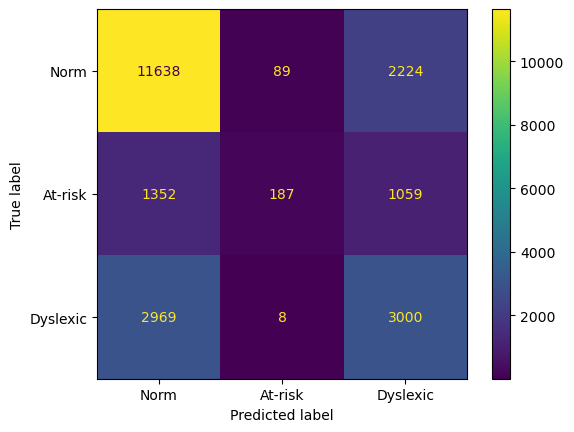

Kappa: 0.2962148451309138 AUC ROC: 0.6433057454559745


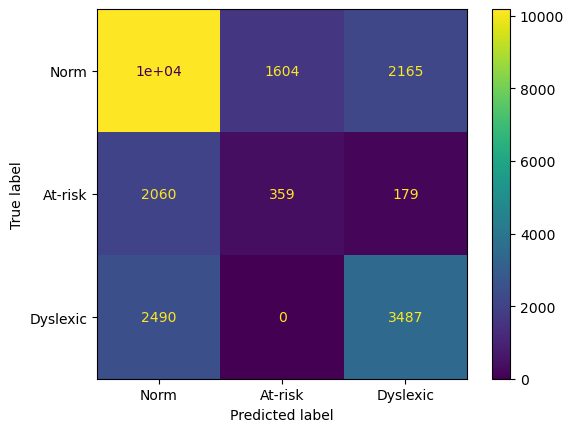

Kappa: 0.2692070160986264 AUC ROC: 0.6652652155188421


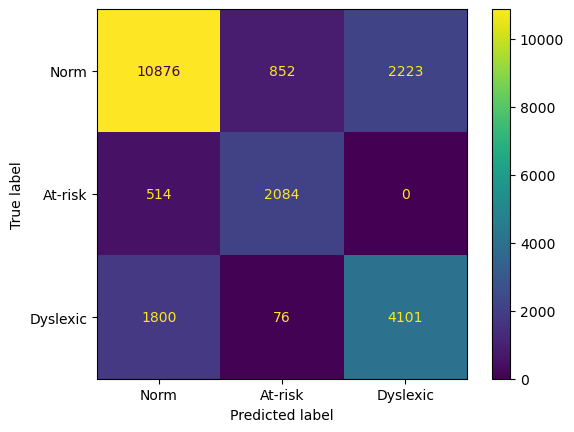

Kappa: 0.5568322255500046 AUC ROC: 0.8616653146018844


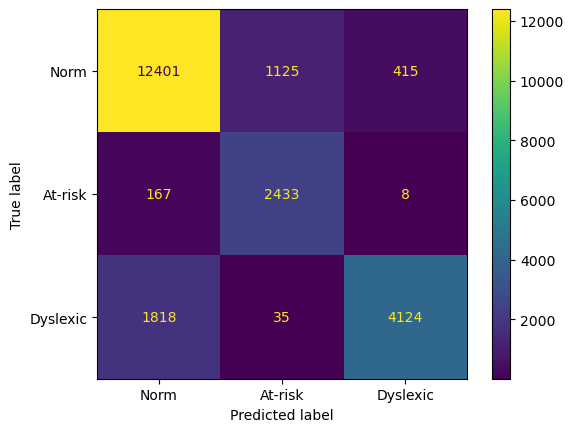

Kappa: 0.7026727020438748 AUC ROC: 0.8823117464358252


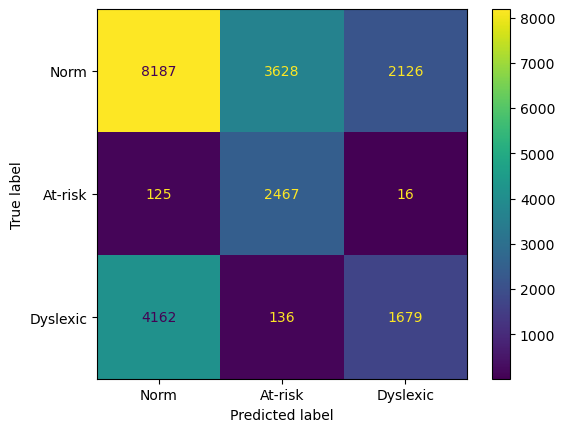

Kappa: 0.2201681272655629 AUC ROC: 0.6347071380322439


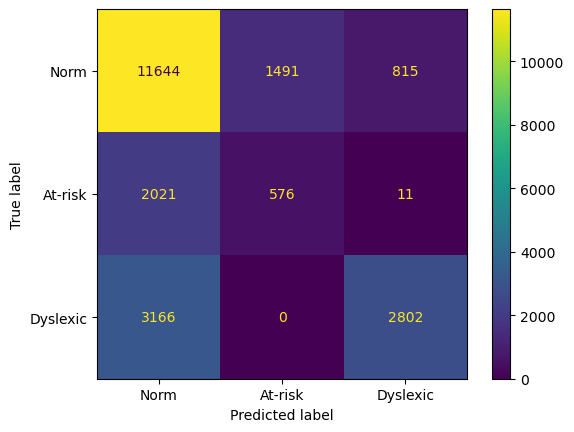

Kappa: 0.3117059239787795 AUC ROC: 0.6547438431220741


NameError: name 'learning_method' is not defined

In [19]:




res = load_a_dict(
    name=configs.specifier + "_n_epochs=" + str(2000),
    save_path=configs.results_path
        )

print_results_per_epochs(res)



## SHAP Analysis (if needed)

In [ ]:

class_names = ['Norm', 'At-risk', 'Dyslexic']




In [ ]:

# results = load_a_dict(
#     name=configs.specifier,
#     save_path=configs.results_path,
#         )




# for i in range(1, 11):
#     i = str(i)
#     y_test_ = results[i]["y_test"]
#     y_pred_ = results[i]["y_pred"]
#     y_prob_ = results[i]["y_pred_prob"]
    
#     cm = sklearn.metrics.confusion_matrix(
#     y_true=y_test_, 
#     y_pred=y_pred_
#     )
    
#     disp = sklearn.metrics.ConfusionMatrixDisplay(confusion_matrix=cm,
#                               display_labels=class_names
#                              )
#     disp.plot()
#     plt.show()
    
    
#     print(
#         "Kappa:", sklearn.metrics.cohen_kappa_score(y1=y_test_, y2=y_pred_),
        
#         "AUC ROC:", sklearn.metrics.roc_auc_score(y_test_, y_prob_,
#                                                   multi_class="ovr",
#                                                   average="weighted")
#     )





In [ ]:


# print_the_evaluated_results(
#     results=results, 
#     learning_method=learning_method
# )



In [ ]:


# mdl.fit(x_train, y_train)



In [ ]:

# print("model fitted")



In [ ]:


# def f(X):
#     return best_model.predict([X[:,i] for i in range(X.shape[1])]).flatten()



In [ ]:

# explainer = shap.DeepExplainer(best_model, 
#                                shap.sample(xx_t_, nsamples=100), 
#                                feature_names=list(x_org.columns),
#                               )


In [ ]:
# xx_t_.shape

In [ ]:


# shap_values = explainer(xx_t_)
# shap_values = explainer.shap_values(shap.sample(xx_t_,nsamples=100))
# shap_values50 = explainer.shap_values(xx_t_[280:330,: ], nsamples=500)





In [ ]:


# print("Shap values are determined!")



In [ ]:
# shap.summary_plot(shap_values, 
#                   x_test, 
#                   plot_type="bar", 
#                   class_names=class_names, 
#                   feature_names=list(x_org.columns),
#                   alpha=0.1,
#                   color_bar=True,
#                   color_bar_label=True
#                  )



### Shap bar plot



In [ ]:

# shap.plots.bar(shap_values, max_display=99, show=False)
# plt.gcf()
# plt.savefig("plots/bar.png")




<!-- - The bar plot above depicgts the Mean Absolute SHAP (MAS) values for each feature across the entire data. MAS, on average, quantifies, the magnitude of each feature's contribution towards the predicted class labels. The higher the MAS value for a a feature the more influential that feature is.


- The gender SHAP values sums up to 0.35 turning it two one of the most influentioal features. 
- IQ, Age and the third and fourth grades are the other important features in predicing the class labels.
- Althoght the remaining features have less significant SHAP values, still they all plan a role in predicting class labels.

- More info on beeswarm-bar plot  -->

In [ ]:
# plt.gcf()
# shap.plots.bar(shap_values.abs.max(0), max_display=99, show=False)
# plt.subplot(2, 1, 2)
# shap.plots.beeswarm(
#     shap_values.abs, color="shap_red", max_display=99, show=False, plot_size=None
# )
# ax = plt.gca()
# masv = {}

# for feature in ax.get_yticklabels():
#     name = feature.get_text()
#     col_ind = x_org.columns.get_loc(name)
#     mean_abs_sv = np.mean(np.abs(shap_values.values[:, col_ind]))
#     masv[name] = mean_abs_sv
# ax.scatter(
#     masv.values(),
#     [i for i in range(len(x_org.columns))],
#     zorder=99,
#     label="Mean Absolute SHAP Value",
#     c="k",
#     marker="|",
#     linewidths=3,
#     s=100,
# )
# ax.legend(frameon=True)
# plt.tight_layout()


# # plt.savefig("plots/bar_beeswarm.png")



##### Beeswarm-bar plot: 
<!-- 
In addition to observe the same pattern on the relative importannce of features, one can observe that:

- There are quite a few sixth grade participants with very high SHAP values despite of its low MAS value in general.

-  -->



### SHAP Beeswarm Plots




In [ ]:
# shap.summary_plot(shap_values=shap_values.values, 
#                   features=x_test,
#                   class_names=["Norm", "at-risk", "Dyslexic"],
#                   feature_names=list(x_org.columns), 
#                  )



<!-- 
- None-female (male) students have the highest negative SHAP values, implying the significance of this feature on prediction results. 


- Only the two extremes of students' "IQ" have direct impacts models prediction.


- Similar to IQ features, only the two extremes of "Age" feature plays an important role in models prediction.


- Most of the 3rd and 4th grade students, unlike the rest of grades, have high SHAP values which demostrates the importance of these two features.


- Fixation along Y-axis is more important than X-axis. 


- The 6th grade has no low impact on model's prediction result. 



 -->

### SHAP Dependence Contribution Plots

<!-- A dependence plot is a scatter plot that shows the effect a single feature has on the predictions made by the model. SHAP dependence contribution plots provide a similar insight to PDP's, but they add a lot more detail.


- Each dot is a single prediction (row) from the dataset.
- The x-axis is the actual value from the dataset.
- The y-axis is the SHAP value for that feature, which represents how much knowing that feature’s value changes the output of the model for that sample’s prediction. -->

In [ ]:
# n = 5
# fig, ax = plt.subplots(1, n, figsize=(15, 5))

# for i, (k, v) in enumerate(sorted(masv.items(), key=lambda x: x[1], reverse=True)):
#     if i < n:
#         shap.plots.scatter(shap_values[:, k], ax=ax[i], show=False, alpha=0.6)
#         ax[i].grid(axis="y")
#         if i != 0:
#             ax[i].set_ylabel("")
#             ax[i].spines["left"].set_visible(False)
#             ax[i].set_ylim(ax[0].get_ylim())
#             ax[i].set_yticklabels(["" for _ in range(len(ax[0].get_yticks()))])
#         else:
#             ax[i].set_ylabel("SHAP value")
# # fig.savefig("plots/scatter_top5.png")

In [ ]:
# n = 5
# fig, ax = plt.subplots(1, n, figsize=(15, 5))

# for i, (k, v) in enumerate(sorted(masv.items(), key=lambda x: x[1], reverse=True)):
#     if i < n:
#         shap.plots.scatter(shap_values[:, k], ax=ax[i], show=False, alpha=0.6)
#         ax[i].grid(axis="y")
#         if i != 0:
#             ax[i].set_ylabel("")
#             ax[i].spines["left"].set_visible(False)
#             ax[i].set_ylim(ax[0].get_ylim())
#             ax[i].set_yticklabels(["" for _ in range(len(ax[0].get_yticks()))])
#         else:
#             ax[i].set_ylabel("SHAP value")
# # fig.savefig("plots/scatter_top5.png")

##### Dependece plots:

- 


In [ ]:
# for i in range(x_test.shape[1]):
#     fig, ax = plt.subplots()
#     shap.plots.scatter(shap_values[:, i], color=shap_values, ax=ax)



- 